# DeepRacer Log Analysis for Model Training
(Compatible with Logs from the AWS DeepRacer Console after Aug 2020)
<br>
___

This Notebook is a redo of Log Analysis solutions provided in the [AWS DeepRacer Workshops repository](https://github.com/aws-samples/aws-deepracer-workshops). The log analysis here parses log data from AWS RoboMaker (SIM_TRACE_LOG data) and Amazon SageMaker (policy training data), and introduces some analyses that are not present in the AWS samples.

With the new AWS DeepRacer console update in Aug 2020, these logs are no longer streamed to CloudWatch Logs during training. Instead, they are downloadable from the model page in the AWS DeepRacer console, after training has terminated.

The code here:
- is compatible with downloaded logs from the new console (after Aug 2020).
- should be backwards compatible with DeepRacer logs previously downloaded from CloudWatch Logs too.
- is maintained such that it can be run directly from a Amazon SageMaker Notebook instance, as long as the relative paths of the RoboMaker and SageMaker log files are specified correctly.
- does not require access to any AWS Services (hence no awscli or boto required) when analysing the log data files.

In [1]:
!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1


In [2]:
# Check Python version
from platform import python_version
print(python_version())

3.6.10


# Import Required Packages

In [3]:
# Install pip packages in the current Jupyter kernel - for packages that are not installed by default
import sys
!{sys.executable} -m pip install shapely

# Add other packages here if import for them fails in the cell below, eg.:
#!{sys.executable} -m pip install numpy pandas matplotlib sklearn shapely boto3

Looking in indexes: http://ftp.daumkakao.com/pypi/simple


In [4]:
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, MultipleLocator
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

from os import listdir
from os.path import isfile, join
import os.path

pd.set_option('display.max_rows', 500, 'display.max_columns', None)

# Specify the RoboMaker & SageMaker Log File Locations

In [5]:
# SPECIFY THE RELATIVE PATH/FILENAMES HERE ACCORDINGLY:
# - robomaker_fname: location of the AWS RoboMaker log file
# - sagemaker_fname: location of the Amazon SageMaker log file
robomaker_fname = 'logs/local-robomaker_50.log'
sagemaker_fname = 'logs/local-sagemaker_50.log'
#robomaker_fname = 'logs/local-202011291437-robomaker.log'
#sagemaker_fname = 'logs/local-202011291437-sagemaker.log'

# Retrieve Training Parameters, Hyperparameters & Action Space from Logs

In [6]:
def parse_robomaker_logs_training_parameters(robomaker_fname, training_parameter_name):
    os_cmd = "cat %s | grep -E '^[{].*[}]$' | grep 'WORLD[_]NAME' | grep 'AWS[_]REGION' | sed \"s/[']/\"'\"/g' | head -1" % (robomaker_fname)
    os_output = !$os_cmd
    training_parameters = json.loads(os_output[0])
    return training_parameters[training_parameter_name]

In [7]:
# Retrieve Training Parameters
'''
try:
    # Works with RoboMaker logs from Aug 2020 onwards
    AWS_REGION = parse_robomaker_logs_training_parameters(robomaker_fname, 'AWS_REGION')
    WORLD_NAME = parse_robomaker_logs_training_parameters(robomaker_fname, 'WORLD_NAME')
    SIMTRACE_S3_PREFIX = parse_robomaker_logs_training_parameters(robomaker_fname, 'SIMTRACE_S3_PREFIX')

    os_cmd = "echo '%s' | sed -e 's/^.*[/]models[/]//g' | cut -d'/' -f1" % (SIMTRACE_S3_PREFIX)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0]

except:
    # Works with older RoboMaker logs
    os_cmd = "cat %s | grep -E '[*][ ][/]AWS[_]REGION[:]' | head -1" % (robomaker_fname)
    AWS_REGION = !$os_cmd
    AWS_REGION = AWS_REGION[0].split(':')[-1].split(' ')[-1]

    os_cmd = "cat %s | grep -E 'gzserver.*[/]worlds[/].*[.]world' | head -1" % (robomaker_fname)
    WORLD_NAME = !$os_cmd
    WORLD_NAME = WORLD_NAME[0].split('/worlds/')[-1].split('.world')[0]

    os_cmd = "cat %s | grep -E 'Successfully[ ]downloaded[ ]model[ ]metadata.*[/]model[_]metadata[.]json' | head -1" % (robomaker_fname)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0].split('/model_metadata.json')[0].split('/')[-1]
'''
    

AWS_REGION='US-EAST'
WORLD_NAME='Monaco_building'
MODEL_NAME='LA21-'

print ('AWS_REGION: %s' % AWS_REGION)
print ('WORLD_NAME: %s' % WORLD_NAME)
print ('MODEL_NAME: %s' % MODEL_NAME)    


AWS_REGION: US-EAST
WORLD_NAME: Monaco_building
MODEL_NAME: LA21-


In [8]:
def parse_robomaker_logs_hyperparameters(robomaker_fname, hyperparameter_name):
    hyperparameter_name = hyperparameter_name.replace('_', '[_]')
    os_cmd = "cat %s | grep -E '^[ ]+[\"]%s[\"][:]' | cut -d':' -f2 | cut -d',' -f1 | sed -e 's/^[ ]*//g'" % (robomaker_fname, hyperparameter_name)
    os_output = !$os_cmd
    return os_output[0]

In [9]:
# Retrieve Hyperparameters

EPISODES_PER_ITERATION = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_episodes_between_training'))
NUM_EPOCHS = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_epochs'))

print ('EPISODES_PER_ITERATION: %s' % EPISODES_PER_ITERATION)
print ('NUM_EPOCHS: %s' % NUM_EPOCHS)

EPISODES_PER_ITERATION: 40
NUM_EPOCHS: 10


In [10]:
# Retrieve Action Space

action_space = !grep '^Reward Distribution Graph.*racecar' $robomaker_fname
action_space = action_space[0].replace('Reward Distribution Graph:', '')
action_space = action_space.replace('racecar', '')
action_space = action_space.replace("'", '"')
action_space = json.loads(action_space)
#action_space = [{'speed': 1.5, 'index': 0, 'steering_angle': -30}, {'speed': 1.9704, 'index': 1, 'steering_angle': -12.7506}, {'speed': 2.8773, 'index': 2, 'steering_angle': -7.0501}, {'speed': 1.7831, 'index': 3, 'steering_angle': -0.6292}, {'speed': 3.9238, 'index': 4, 'steering_angle': -0.0239}, {'speed': 3.3736, 'index': 5, 'steering_angle': 0.875}, {'speed': 2.3195, 'index': 6, 'steering_angle': 6.1889}, {'speed': 2.8651, 'index': 7, 'steering_angle': 7.3838}, {'speed': 1.785, 'index': 8, 'steering_angle': 13.6619}, {'speed': 1.5, 'index': 9, 'steering_angle': 30}]
action_space

[{'speed': 1.2, 'index': 0, 'steering_angle': -30.0},
 {'speed': 1.4, 'index': 1, 'steering_angle': -23.0},
 {'speed': 1.5, 'index': 2, 'steering_angle': -18.9},
 {'speed': 2.0, 'index': 3, 'steering_angle': -12.1},
 {'speed': 2.5, 'index': 4, 'steering_angle': -8.0},
 {'speed': 2.8, 'index': 5, 'steering_angle': -6.0},
 {'speed': 2.8, 'index': 6, 'steering_angle': -3.4},
 {'speed': 2.5, 'index': 7, 'steering_angle': -2.7},
 {'speed': 2.0, 'index': 8, 'steering_angle': -0.5},
 {'speed': 2.8, 'index': 9, 'steering_angle': -0.3},
 {'speed': 3.6, 'index': 10, 'steering_angle': 0},
 {'speed': 2.8, 'index': 11, 'steering_angle': 0.9},
 {'speed': 2.0, 'index': 12, 'steering_angle': 3.6},
 {'speed': 2.5, 'index': 13, 'steering_angle': 6.4},
 {'speed': 2.8, 'index': 14, 'steering_angle': 7.7},
 {'speed': 1.5, 'index': 15, 'steering_angle': 8.5},
 {'speed': 2.5, 'index': 16, 'steering_angle': 12.0},
 {'speed': 2.0, 'index': 17, 'steering_angle': 15.2},
 {'speed': 1.5, 'index': 18, 'steering_ang

In [11]:
action_names = []
for action in action_space:
    action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
    action_speed = ('SPD:%.2f' % action['speed'])
    action_names.append(action_steering + ' / ' + action_speed)
action_names

['RIGHT:30.0 / SPD:1.20',
 'RIGHT:23.0 / SPD:1.40',
 'RIGHT:18.9 / SPD:1.50',
 'RIGHT:12.1 / SPD:2.00',
 'RIGHT:8.0 / SPD:2.50',
 'RIGHT:6.0 / SPD:2.80',
 'RIGHT:3.4 / SPD:2.80',
 'RIGHT:2.7 / SPD:2.50',
 'RIGHT:0.5 / SPD:2.00',
 'RIGHT:0.3 / SPD:2.80',
 'CENTER:0.0 / SPD:3.60',
 'LEFT:0.9 / SPD:2.80',
 'LEFT:3.6 / SPD:2.00',
 'LEFT:6.4 / SPD:2.50',
 'LEFT:7.7 / SPD:2.80',
 'LEFT:8.5 / SPD:1.50',
 'LEFT:12.0 / SPD:2.50',
 'LEFT:15.2 / SPD:2.00',
 'LEFT:19.0 / SPD:1.50',
 'LEFT:23.0 / SPD:1.40',
 'LEFT:30.0 / SPD:1.20']

In [12]:
action_speed = list()
action_steering = list()

for action in action_space:
    action_speed.append(action['speed'])
    action_steering.append(action['steering_angle'])

print ('SPEED: %s' % action_speed)
print ('STEERING: %s' % action_steering)

action_min_speed = min(action_speed)
action_max_speed = max(action_speed)
action_min_steering = min(action_steering)
action_max_steering = max(action_steering)

print ('MIN SPEED: %f' % action_min_speed)
print ('MAX SPEED: %f' % action_max_speed)
print ('MIN STEERING: %f' % action_min_steering)
print ('MAX STEERING: %f' % action_max_steering)

action_speed_range = action_max_speed - action_min_speed
action_steering_range = action_max_steering - action_min_steering

print ('SPEED RANGE: %f' % action_speed_range)
print ('STEERING RANGE: %f' % action_steering_range)


SPEED: [1.2, 1.4, 1.5, 2.0, 2.5, 2.8, 2.8, 2.5, 2.0, 2.8, 3.6, 2.8, 2.0, 2.5, 2.8, 1.5, 2.5, 2.0, 1.5, 1.4, 1.2]
STEERING: [-30.0, -23.0, -18.9, -12.1, -8.0, -6.0, -3.4, -2.7, -0.5, -0.3, 0, 0.9, 3.6, 6.4, 7.7, 8.5, 12.0, 15.2, 19.0, 23.0, 30.0]
MIN SPEED: 1.200000
MAX SPEED: 3.600000
MIN STEERING: -30.000000
MAX STEERING: 30.000000
SPEED RANGE: 2.400000
STEERING RANGE: 60.000000


# Parse *Simulation* Job (AWS RoboMaker) Logs

In [13]:
# Check that the RoboMaker Log file exists

print('RoboMaker Log file size: %d' % os.stat(robomaker_fname).st_size)
!tail $robomaker_fname

RoboMaker Log file size: 46470364

distance: 2.60 , same_lane: True , reward: 4.00 , waypoints: [191, 192] , next_object_index: 5  objects_waypoint_index [11, 47, 94, 107, 171, 205]
SIM_TRACE_LOG:971,76,-5.1016,-4.2538,-83.6215,3.60,2.00,12,4.0000,False,True,26.3517,192,60.27,1607221942.6584563,in_progress

distance: 2.41 , same_lane: True , reward: 4.00 , waypoints: [192, 193] , next_object_index: 5  objects_waypoint_index [11, 47, 94, 107, 171, 205]
SIM_TRACE_LOG:971,77,-5.0504,-4.4776,-79.2725,6.40,2.50,13,4.0000,False,True,26.7061,192,60.27,1607221942.7952087,in_progress

distance: 2.21 , same_lane: True , reward: 4.00 , waypoints: [193, 194] , next_object_index: 5  objects_waypoint_index [11, 47, 94, 107, 171, 205]
SIM_TRACE_LOG:971,78,-4.9579,-4.7528,-72.8511,-8.00,2.50,4,4.0000,False,True,27.1766,194,60.27,1607221942.9082954,in_progress



In [14]:
# Retrieve SIM_TRACE_LOGs from the RoboMaker Log file

sim_data = []
with open(robomaker_fname, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            parts = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_data.append(",".join(parts))
sim_data[-20:]

['971,59,-4.3501,-0.8420,-130.5198,8.50,1.50,15,4.0257,False,True,19.5418,172,60.27,1607221940.8047867,in_progress',
 '971,60,-4.4513,-1.0411,-121.2429,3.60,2.00,12,4.4502,False,True,20.1567,175,60.27,1607221940.9092221,in_progress',
 '971,61,-4.5092,-1.1857,-116.3183,-2.70,2.50,7,4.8104,False,True,20.6261,176,60.27,1607221941.017044,in_progress',
 '971,62,-4.5789,-1.3726,-112.7911,-2.70,2.50,7,4.7054,False,True,21.0788,178,60.27,1607221941.1178324,in_progress',
 '971,63,-4.6476,-1.5693,-110.6073,-2.70,2.50,7,4.0432,False,True,21.4129,179,60.27,1607221941.228283,in_progress',
 '971,64,-4.7157,-1.7702,-109.4000,-2.70,2.50,7,0.0010,False,True,21.6877,180,60.27,1607221941.3358493,in_progress',
 '971,65,-4.7830,-1.9742,-108.6863,-2.70,2.50,7,0.0010,False,True,21.9637,180,60.27,1607221941.4526308,in_progress',
 '971,66,-4.8630,-2.2164,-108.4544,-2.70,2.50,7,0.0010,False,True,22.3361,181,60.27,1607221941.560302,in_progress',
 '971,67,-4.9278,-2.4047,-108.9238,3.60,2.00,12,0.0010,False,True,2

In [15]:
# Parse the SIM_TRACE_LOG data

df_list = list()

# Ignore the first two dummy values that coach throws at the start
# (not sure if it's still necessary to do so?)
for d in sim_data[2:]:
    parts = d.rstrip().split(",")
    episode = int(parts[0])
    steps = int(parts[1])
    x = 100*float(parts[2])
    y = 100*float(parts[3])
    ##cWp = get_closest_waypoint(x, y, wpts)
    yaw = float(parts[4])
    steer = float(parts[5])
    throttle = float(parts[6])
    action = float(parts[7])
    reward = float(parts[8])
    done = 0 if 'False' in parts[9] else 1
    all_wheels_on_track = parts[10]
    progress = float(parts[11])
    closest_waypoint = int(parts[12])
    track_len = float(parts[13])
    tstamp = float(parts[14])
    status = parts[15]

    #iteration = int(episode / EPISODES_PER_ITERATION) + 1
    iteration = int(episode / EPISODES_PER_ITERATION) # remove 1
    if (iteration == 0) and (episode == 0):
        steps -= 2
    episode_in_iteration = (episode % EPISODES_PER_ITERATION) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, all_wheels_on_track, progress,
                    closest_waypoint, track_len, tstamp, status))

header = ['iteration', 'episode_in_iteration', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle', 'action', 'reward', 'done', 'on_track', 'progress', 'closest_waypoint', 'track_len', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df

iteration  episode_in_iteration  episode  steps       x       y  \
0              0                     1        1      1 -724.02   87.97   
1              0                     1        1      2 -721.96   92.71   
2              0                     1        1      3 -718.26  101.70   
3              0                     1        1      4 -713.08  114.55   
4              0                     1        1      5 -704.92  133.46   
...          ...                   ...      ...    ...     ...     ...   
84086         24                    12      972     74 -514.50 -386.34   
84087         24                    12      972     75 -513.46 -402.82   
84088         24                    12      972     76 -510.16 -425.38   
84089         24                    12      972     77 -505.04 -447.76   
84090         24                    12      972     78 -495.79 -475.28   

           yaw  steer  throttle  action  reward  done on_track  progress  \
0      62.7004    7.7       2.8    14.0  3.2017     0     True    0.3224   
1      63.5577    0.9       2.8    11.0  3.1949     0     True    0.4079   
2      65.0370    0.9       2.8    11.0  3.6667     0     True    0.5681   
3      66.5182   -2.7       2.5     7.0  3.1960     0     True    0.7963   
4      66.4610   -8.0       2.5     4.0  3.6147     0     True    1.1354   
...        ...    ...       ...     ...     ...   ...      ...       ...   
84086 -90.0252    3.6       2.0    12.0  4.0000     0     True   25.7595   
84087 -88.0940    6.4       2.5    13.0  4.0000     0     True   26.0016   
84088 -83.6215    3.6       2.0    12.0  4.0000     0     True   26.3517   
84089 -79.2725    6.4       2.5    13.0  4.0000     0     True   26.7061   
84090 -72.8511   -8.0       2.5     4.0  4.0000     0     True   27.1766   

       closest_waypoint  track_len     timestamp       status  
0                     1      60.27  1.607211e+09  in_progress  
1                     1      60.27  1.607211e+09  in_progress  
2                     1      60.27  1.607211e+09  in_progress  
3                     1      60.27  1.607211e+09  in_progress  
4                     2      60.27  1.607211e+09  in_progress  
...                 ...        ...           ...          ...  
84086               190      60.27  1.607222e+09  in_progress  
84087               191      60.27  1.607222e+09  in_progress  
84088               192      60.27  1.607222e+09  in_progress  
84089               192      60.27  1.607222e+09  in_progress  
84090               194      60.27  1.607222e+09  in_progress  

[84091 rows x 18 columns]

In [16]:
# Calculate episode-related data

sim_df_episodes = sim_df[sim_df["done"] == 1][["iteration", "episode_in_iteration", "episode", "steps", "progress", "status"]].copy()
sim_df_episodes["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
sim_df_episodes["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")

sim_df_episodes[sim_df_episodes['episode_in_iteration']==1]

iteration  episode_in_iteration  episode  steps  progress     status  \
147            0                     1        1    148   46.6086    crashed   
2444           1                     1       41    111   30.6014    crashed   
5740           2                     1       81     71   20.2662    crashed   
8647           3                     1      121    176   50.7454    crashed   
12322          4                     1      161     34    8.5428  off_track   
15883          5                     1      201     32    8.8388    crashed   
19613          6                     1      241     57   15.4733    crashed   
23028          7                     1      281     11    0.5644  off_track   
26432          8                     1      321    116   29.7771  off_track   
30104          9                     1      361     13   -0.6456  off_track   
33586         10                     1      401    142   43.2840    crashed   
37301         11                     1      441     70   23.1708    crashed   
40781         12                     1      481     90   24.7395    crashed   
44998         13                     1      521     47   13.8585    crashed   
49106         14                     1      561     81   26.0775    crashed   
52141         15                     1      601     25    7.3670    crashed   
55510         16                     1      641     93   29.4966    crashed   
59139         17                     1      681    226   67.2296    crashed   
62868         18                     1      721    178   53.1758    crashed   
65800         19                     1      761     32    9.3353  off_track   
69202         20                     1      801     15    2.0103  off_track   
72626         21                     1      841     47   13.9422    crashed   
76110         22                     1      881     60   17.8934    crashed   
79292         23                     1      921     66   20.8078    crashed   
82783         24                     1      961    268   90.4250    crashed   

       episode_total_rewards  elapsed_time    start_time      end_time  
147                 423.7546     15.354331  1.607211e+09  1.607211e+09  
2444                179.4003     12.007771  1.607211e+09  1.607211e+09  
5740                145.4626      7.556653  1.607212e+09  1.607212e+09  
8647                506.2158     18.010496  1.607212e+09  1.607212e+09  
12322               136.0000      3.466891  1.607213e+09  1.607213e+09  
15883                91.3378      3.446737  1.607213e+09  1.607213e+09  
19613               109.9715      6.880746  1.607214e+09  1.607214e+09  
23028                 6.2259      1.107955  1.607214e+09  1.607214e+09  
26432               187.7649     12.225916  1.607214e+09  1.607214e+09  
30104                 3.2296      1.213162  1.607215e+09  1.607215e+09  
33586               345.9365     14.739322  1.607215e+09  1.607215e+09  
37301               122.6244      7.584016  1.607216e+09  1.607216e+09  
40781               139.3023      9.493982  1.607216e+09  1.607216e+09  
44998               121.9721      4.764085  1.607217e+09  1.607217e+09  
49106               211.9086      8.436294  1.607217e+09  1.607217e+09  
52141                73.2085      2.523840  1.607218e+09  1.607218e+09  
55510               264.5788      9.506443  1.607218e+09  1.607218e+09  
59139               466.5897     24.660240  1.607219e+09  1.607219e+09  
62868               421.0519     18.434699  1.607219e+09  1.607219e+09  
65800                49.5576      3.277682  1.607220e+09  1.607220e+09  
69202                 9.6826      1.579094  1.607220e+09  1.607220e+09  
72626               100.3555      4.722151  1.607220e+09  1.607220e+09  
76110               137.1109      6.454945  1.607221e+09  1.607221e+09  
79292               112.0368      6.935818  1.607221e+09  1.607221e+09  
82783               615.1251     28.491826  1.607222e+09  1.607222e+09

In [17]:
# Calculate iteration-related data

sim_df_iterations = sim_df_episodes[sim_df_episodes["episode_in_iteration"] == 1][["iteration"]].copy()
sim_df_iterations["min_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("min")
sim_df_iterations["max_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("max")
sim_df_iterations["avg_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("mean")
sim_df_iterations["total_rewards"] = sim_df.groupby("iteration")["reward"].transform("sum")
sim_df_iterations["start_time"] = sim_df_episodes.groupby("iteration")["start_time"].transform("min")
sim_df_iterations["end_time"] = sim_df_episodes.groupby("iteration")["end_time"].transform("max")

lap_count = sim_df_episodes[sim_df_episodes["progress"] >= 100.0].groupby("iteration")["progress"].count()
sim_df_iterations = pd.merge(sim_df_iterations,lap_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"progress":"completed_laps"}, inplace=True)
sim_df_iterations["completed_laps"].fillna(0, inplace=True)
sim_df_iterations["completed_laps"] = sim_df_iterations["completed_laps"].astype(int)

episode_count = sim_df_episodes.groupby("iteration")["episode_in_iteration"].count()
sim_df_iterations = pd.merge(sim_df_iterations,episode_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"episode_in_iteration":"episodes"}, inplace=True)
sim_df_iterations["pct_completed_laps"] = (sim_df_iterations["completed_laps"] / sim_df_iterations["episodes"] * 100.0)

if (sim_df_iterations.tail(1)['episodes'].values[0] < EPISODES_PER_ITERATION):
    sim_df_iterations.drop(sim_df_iterations.tail(1).index,inplace=True)
sim_df_iterations

iteration  min_progress  max_progress  avg_progress  total_rewards  \
0           0       -4.1352       52.8441     16.557912      6037.5535   
1           1       -3.4173      100.0000     25.097850      7997.6389   
2           2       -3.5827       59.8881     20.911995      7106.6878   
3           3       -0.4203       77.0870     29.053945      9306.2044   
4           4       -0.3302      100.0000     28.021430      9226.5534   
5           5       -1.2406      100.0000     27.899350      9058.0302   
6           6       -3.7646      100.0000     24.983383      8568.3719   
7           7       -2.3299      100.0000     24.599433      7759.7248   
8           8       -4.1578      100.0000     28.166777      9314.6718   
9           9       -4.1370       80.0896     25.467268      8758.2666   
10         10       -3.1327      100.0000     28.639345      9421.8510   
11         11       -2.8474      100.0000     25.801732      8554.8430   
12         12       -0.8657      100.0000     32.547477     10258.7483   
13         13       -2.2180      100.0000     31.528090      9769.0862   
14         14       -2.4565      100.0000     23.286830      7801.7247   
15         15       -2.7992      100.0000     24.012268      7699.0873   
16         16       -4.7167       78.8946     26.110085      8305.0385   
17         17       -2.8138      100.0000     27.968440      9124.1011   
18         18       -2.9436      100.0000     22.604945      7369.8848   
19         19       -3.3200      100.0000     26.145087      8255.9319   
20         20        0.0451      100.0000     25.167605      7809.1461   
21         21       -3.3534      100.0000     25.541440      7938.8495   
22         22       -0.6143       86.6749     22.904378      7936.9639   
23         23       -1.8717      100.0000     24.672043      7559.5407   

      start_time      end_time  completed_laps  episodes  pct_completed_laps  
0   1.607211e+09  1.607211e+09               0        40                 0.0  
1   1.607211e+09  1.607212e+09               1        40                 2.5  
2   1.607212e+09  1.607212e+09               0        40                 0.0  
3   1.607212e+09  1.607213e+09               0        40                 0.0  
4   1.607213e+09  1.607213e+09               3        40                 7.5  
5   1.607213e+09  1.607214e+09               1        40                 2.5  
6   1.607214e+09  1.607214e+09               1        40                 2.5  
7   1.607214e+09  1.607214e+09               2        40                 5.0  
8   1.607214e+09  1.607215e+09               1        40                 2.5  
9   1.607215e+09  1.607215e+09               0        40                 0.0  
10  1.607215e+09  1.607216e+09               1        40                 2.5  
11  1.607216e+09  1.607216e+09               1        40                 2.5  
12  1.607216e+09  1.607217e+09               1        40                 2.5  
13  1.607217e+09  1.607217e+09               3        40                 7.5  
14  1.607217e+09  1.607218e+09               2        40                 5.0  
15  1.607218e+09  1.607218e+09               1        40                 2.5  
16  1.607218e+09  1.607219e+09               0        40                 0.0  
17  1.607219e+09  1.607219e+09               2        40                 5.0  
18  1.607219e+09  1.607220e+09               1        40                 2.5  
19  1.607220e+09  1.607220e+09               1        40                 2.5  
20  1.607220e+09  1.607220e+09               2        40                 5.0  
21  1.607220e+09  1.607221e+09               1        40                 2.5  
22  1.607221e+09  1.607221e+09               0        40                 0.0  
23  1.607221e+09  1.607222e+09               1        40                 2.5

In [18]:
# Calculate aggregated values for iterations

x = sim_df_iterations[['total_rewards']].values.astype(float)
if (len(x)>0):
    min_max_scaler = MinMaxScaler(feature_range=(5,95))
    x_scaled = min_max_scaler.fit_transform(x)
    sim_df_iterations['total_rewards_normalized'] = x_scaled
    sim_df_iterations

In [19]:
print ('%d' % len(sim_df_iterations))
if (len(sim_df_iterations) > 0):
    sim_df_iterations['total_rewards_normalized_SMA3'] = sim_df_iterations['total_rewards_normalized'].rolling(window=3).mean()
    sim_df_iterations['min_progress_SMA3'] = sim_df_iterations['min_progress'].rolling(window=3).mean()
    sim_df_iterations['max_progress_SMA3'] = sim_df_iterations['max_progress'].rolling(window=3).mean()
    sim_df_iterations['avg_progress_SMA3'] = sim_df_iterations['avg_progress'].rolling(window=3).mean()
    sim_df_iterations['pct_completed_laps_SMA3'] = sim_df_iterations['pct_completed_laps'].rolling(window=3).mean()

sim_df_iterations

24


iteration  min_progress  max_progress  avg_progress  total_rewards  \
0           0       -4.1352       52.8441     16.557912      6037.5535   
1           1       -3.4173      100.0000     25.097850      7997.6389   
2           2       -3.5827       59.8881     20.911995      7106.6878   
3           3       -0.4203       77.0870     29.053945      9306.2044   
4           4       -0.3302      100.0000     28.021430      9226.5534   
5           5       -1.2406      100.0000     27.899350      9058.0302   
6           6       -3.7646      100.0000     24.983383      8568.3719   
7           7       -2.3299      100.0000     24.599433      7759.7248   
8           8       -4.1578      100.0000     28.166777      9314.6718   
9           9       -4.1370       80.0896     25.467268      8758.2666   
10         10       -3.1327      100.0000     28.639345      9421.8510   
11         11       -2.8474      100.0000     25.801732      8554.8430   
12         12       -0.8657      100.0000     32.547477     10258.7483   
13         13       -2.2180      100.0000     31.528090      9769.0862   
14         14       -2.4565      100.0000     23.286830      7801.7247   
15         15       -2.7992      100.0000     24.012268      7699.0873   
16         16       -4.7167       78.8946     26.110085      8305.0385   
17         17       -2.8138      100.0000     27.968440      9124.1011   
18         18       -2.9436      100.0000     22.604945      7369.8848   
19         19       -3.3200      100.0000     26.145087      8255.9319   
20         20        0.0451      100.0000     25.167605      7809.1461   
21         21       -3.3534      100.0000     25.541440      7938.8495   
22         22       -0.6143       86.6749     22.904378      7936.9639   
23         23       -1.8717      100.0000     24.672043      7559.5407   

      start_time      end_time  completed_laps  episodes  pct_completed_laps  \
0   1.607211e+09  1.607211e+09               0        40                 0.0   
1   1.607211e+09  1.607212e+09               1        40                 2.5   
2   1.607212e+09  1.607212e+09               0        40                 0.0   
3   1.607212e+09  1.607213e+09               0        40                 0.0   
4   1.607213e+09  1.607213e+09               3        40                 7.5   
5   1.607213e+09  1.607214e+09               1        40                 2.5   
6   1.607214e+09  1.607214e+09               1        40                 2.5   
7   1.607214e+09  1.607214e+09               2        40                 5.0   
8   1.607214e+09  1.607215e+09               1        40                 2.5   
9   1.607215e+09  1.607215e+09               0        40                 0.0   
10  1.607215e+09  1.607216e+09               1        40                 2.5   
11  1.607216e+09  1.607216e+09               1        40                 2.5   
12  1.607216e+09  1.607217e+09               1        40                 2.5   
13  1.607217e+09  1.607217e+09               3        40                 7.5   
14  1.607217e+09  1.607218e+09               2        40                 5.0   
15  1.607218e+09  1.607218e+09               1        40                 2.5   
16  1.607218e+09  1.607219e+09               0        40                 0.0   
17  1.607219e+09  1.607219e+09               2        40                 5.0   
18  1.607219e+09  1.607220e+09               1        40                 2.5   
19  1.607220e+09  1.607220e+09               1        40                 2.5   
20  1.607220e+09  1.607220e+09               2        40                 5.0   
21  1.607220e+09  1.607221e+09               1        40                 2.5   
22  1.607221e+09  1.607221e+09               0        40                 0.0   
23  1.607221e+09  1.607222e+09               1        40                 2.5   

    total_rewards_normalized  total_rewards_normalized_SMA3  \
0                   5.000000                            NaN   
1                  46.7909

# Parse *Training* Job (Amazon SageMaker) Logs

In [20]:
# Check that the SageMaker Log file exists

print('SageMaker Log file size: %d' % os.stat(sagemaker_fname).st_size)
!tail $sagemaker_fname

SageMaker Log file size: 170742












In [21]:
# Retrieve policy training data from the SageMaker Log file

trn_data = []
last_iteration_id = 0
with open(sagemaker_fname, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            parts = line.split("Training> Name=main_level/agent, ")[1].split('\t')[0].split('\n')[0].split(',')
            last_iteration_id = [parts[-1].split('=')[1]]
        if "Policy training> " in line:
            parts = line.split("Policy training> ")[1].split('\t')[0].split('\n')[0].split(',')
            parts = [x.split('=')[1] for x in parts]
            trn_data.append(",".join(last_iteration_id + parts))
trn_data[1:20]

['0,0.004744585137814283,7.594084308948368e-05,0.7129247188568115,1,1e-06',
 '0,-0.010262884199619293,0.00021201596246100962,0.7122622728347778,2,1e-06',
 '0,-0.012489189393818378,0.00039321783697232604,0.7147066593170166,3,1e-06',
 '0,-0.00803739670664072,0.0006182147772051394,0.7127254605293274,4,1e-06',
 '0,-0.009836146607995033,0.0009095013374462724,0.705366849899292,5,1e-06',
 '0,-0.014533651992678642,0.0012218353804200888,0.7142452001571655,6,1e-06',
 '0,-0.00256967730820179,0.0015240480424836278,0.7162918448448181,7,1e-06',
 '0,-0.0006817188113927841,0.0018283601384609938,0.7100514769554138,8,1e-06',
 '0,-0.018152153119444847,0.0021392288617789745,0.7165678143501282,9,1e-06',
 '1,0.0029252127278596163,6.830306574556744e-06,0.7280001044273376,0,1e-06',
 '1,0.00207387562841177,7.613683555973694e-05,0.7302173972129822,1,1e-06',
 '1,0.0015298462240025401,0.0003056327404920012,0.729081928730011,2,1e-06',
 '1,-0.005057201255112886,0.0007812261465005577,0.7281379699707031,3,1e-06',
 '1

In [22]:
# Parse the policy training data

df_list = list()

for d in trn_data:
    parts = d.rstrip().split(",")
    iteration = int(parts[0]) # elimate +1, add 1 so as to match model.pb (training iteration n == model.pb n+1) 
    surrogate_loss = float(parts[1])
    kl_divergence = float(parts[2])
    entropy = float(parts[3])
    training_epoch = int(parts[4]) + 1
    learning_rate = float(parts[5])

    df_list.append((iteration, surrogate_loss, kl_divergence, entropy, training_epoch, learning_rate))

header = ['iteration', 'surrogate_loss', 'kl_divergence', 'entropy', 'training_epoch', 'learning_rate']
trn_df = pd.DataFrame(df_list, columns=header)
trn_df

iteration  surrogate_loss  kl_divergence   entropy  training_epoch  \
0            0       -0.011335       0.000012  0.710150               1   
1            0        0.004745       0.000076  0.712925               2   
2            0       -0.010263       0.000212  0.712262               3   
3            0       -0.012489       0.000393  0.714707               4   
4            0       -0.008037       0.000618  0.712725               5   
5            0       -0.009836       0.000910  0.705367               6   
6            0       -0.014534       0.001222  0.714245               7   
7            0       -0.002570       0.001524  0.716292               8   
8            0       -0.000682       0.001828  0.710051               9   
9            0       -0.018152       0.002139  0.716568              10   
10           1        0.002925       0.000007  0.728000               1   
11           1        0.002074       0.000076  0.730217               2   
12           1        0.001530       0.000306  0.729082               3   
13           1       -0.005057       0.000781  0.728138               4   
14           1       -0.004639       0.001483  0.727441               5   
15           1       -0.007139       0.002236  0.731157               6   
16           1       -0.018132       0.002766  0.729230               7   
17           1       -0.017733       0.003036  0.729934               8   
18           1       -0.017787       0.003088  0.733166               9   
19           1       -0.017995       0.003002  0.724733              10   
20           2        0.002234       0.000002  0.717767               1   
21           2        0.004079       0.000021  0.713671               2   
22           2        0.001606       0.000104  0.714688               3   
23           2       -0.002102       0.000292  0.713784               4   
24           2       -0.010784       0.000590  0.716610               5   
25           2       -0.015437       0.000976  0.711891               6   
26           2       -0.016748       0.001474  0.716921               7   
27           2       -0.018392       0.001960  0.719125               8   
28           2       -0.009676       0.002281  0.719186               9   
29           2       -0.015117       0.002523  0.719345              10   
30           3       -0.004170       0.000003  0.694240               1   
31           3       -0.003673       0.000025  0.697945               2   
32           3       -0.004819       0.000097  0.695554               3   
33           3       -0.001618       0.000253  0.694442               4   
34           3       -0.002083       0.000525  0.693243               5   
35           3       -0.008473       0.000813  0.695318               6   
36           3       -0.014475       0.001072  0.692023               7   
37           3       -0.015076       0.001244  0.689746               8   
38           3       -0.015320       0.001425  0.687918               9   
39           3       -0.012398       0.001557  0.689021              10   
40           4        0.006236       0.000002  0.710350               1   
41           4       -0.004129       0.000025  0.702353               2   
42           4        0.007236       0.000111  0.709264               3   
43           4       -0.014578       0.000298  0.709096               4   
44           4       -0.010343       0.000579  0.711204               5   
45           4       -0.015829       0.000976  0.710683               6   
46           4       -0.015063       0.001330  0.709666               7   
47           4       -0.012931       0.001631  0.709007               8   
48           4       -0.019861       0.001809  0.707525               9   
49           4       -0.022561       0.001967  0.709993              10   
50           5        0.002470       0.000004  0.691037               1   
51           5        0.000133       0.000045  0.692433               2   
52           5       -0.001615

In [23]:
# Calculate aggregated values for iterations

if (len(trn_df)>0):
    trn_df["avg_entropy"] = trn_df.groupby("iteration")["entropy"].transform("mean")
    trn_df_entropy = trn_df[trn_df["training_epoch"] == 1][['iteration', 'avg_entropy']]

trn_df_entropy['avg_entropy_SMA3'] = trn_df_entropy.iloc[:,1].rolling(window=3).mean()
trn_df_entropy

iteration  avg_entropy  avg_entropy_SMA3
0            0     0.712529               NaN
10           1     0.729110               NaN
20           2     0.716299          0.719313
30           3     0.692945          0.712785
40           4     0.708914          0.706053
50           5     0.695030          0.698963
60           6     0.708486          0.704143
70           7     0.704933          0.702817
80           8     0.696226          0.703215
90           9     0.709147          0.703436
100         10     0.711146          0.705506
110         11     0.702183          0.707492
120         12     0.701283          0.704870
130         13     0.724017          0.709161
140         14     0.720524          0.715275
150         15     0.703235          0.715925
160         16     0.706961          0.710240
170         17     0.706891          0.705696
180         18     0.722108          0.711987
190         19     0.708015          0.712338
200         20     0.689680          0.706601
210         21     0.707253          0.701649
220         22     0.689200          0.695378
230         23     0.731184          0.709213

# Check Convergence - Plot Rewards vs Episodes/Iterations

Number of episodes =  972
Number of complete iterations =  23


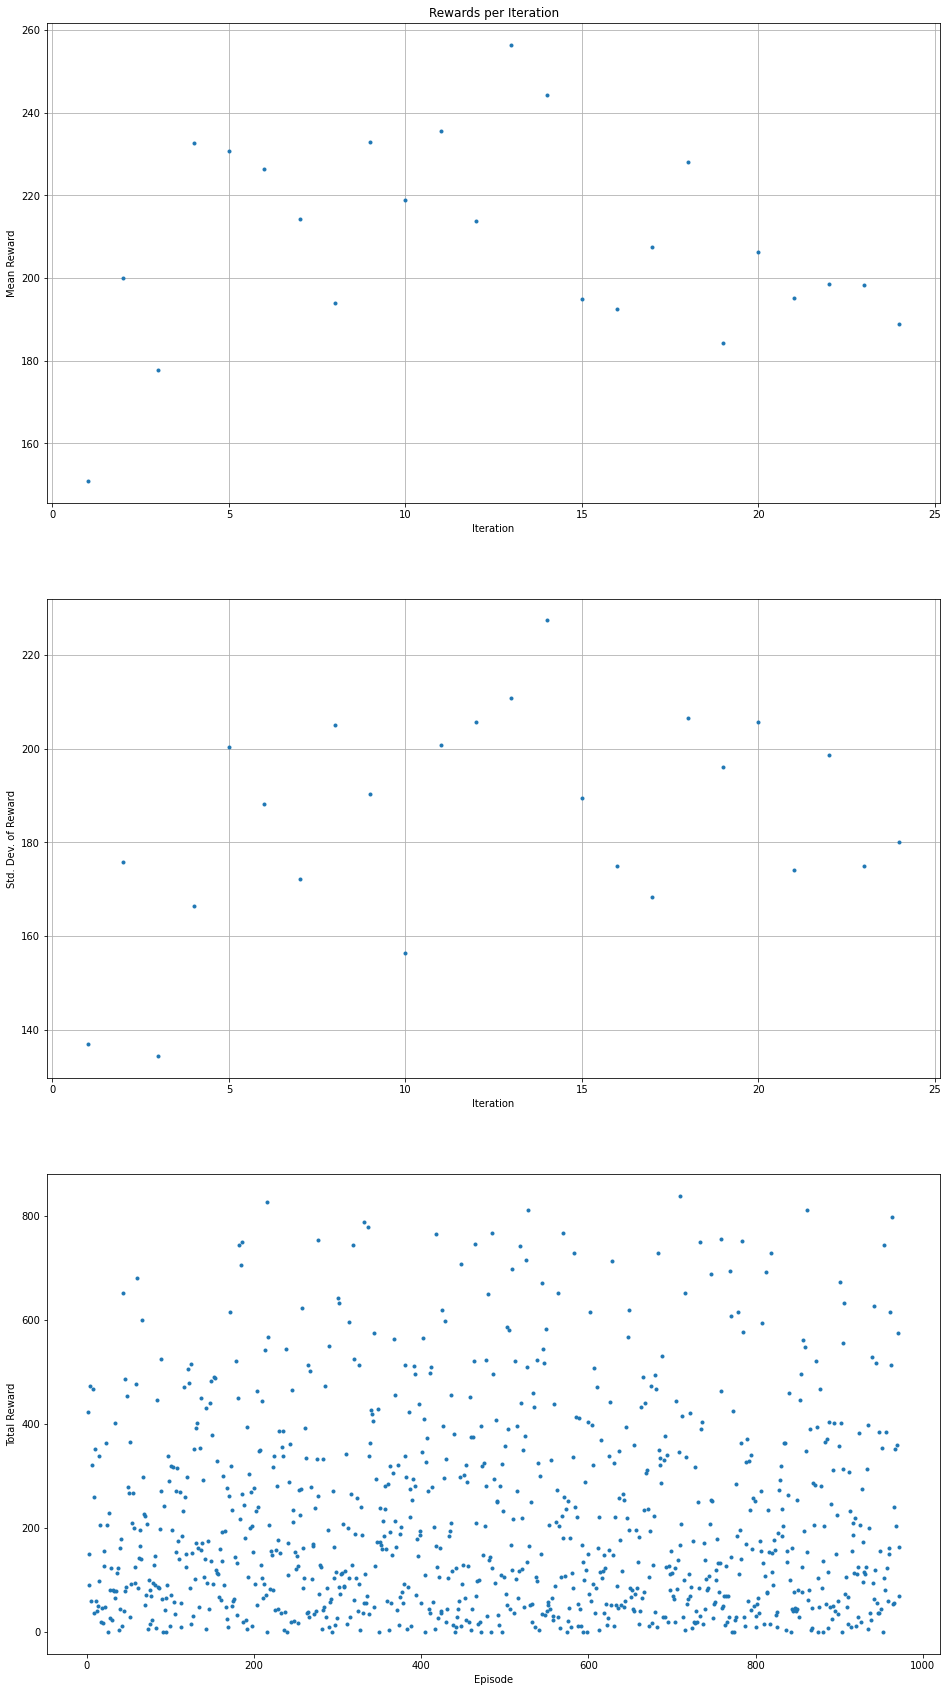

In [24]:
# Reward graph per episode
max_episode = np.max(sim_df['episode'])
max_iteration = np.max(sim_df_iterations['iteration'])
print('Number of episodes = ', max_episode)
print('Number of complete iterations = ', max_iteration)

total_reward_per_episode = list()
for epi in range(1, max_episode + 1):
    df_slice = sim_df[sim_df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()

fig = plt.figure(figsize=(16, 10*3))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration))+1, average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration))+1, deviation_reward_per_iteration, '.')
ax.set_ylabel('Std. Dev. of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode))+1, total_reward_per_episode, '.')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Episode')
plt.grid(False)

# Check Correlation Between Steps and Lap Times
- Plot steps vs lap times to gauge the potential increasae in lap time for every step taken; this can also be used to extrapolate the target number of steps needed in order to achieve a certain lap time

# Check that Rewards Correlate with Performance
- Plot rewards vs lap times as a sanity check for our Reward Function logic

# Determine the Performance Envelope of the Model
- Plot a histogram of lap times to work out statistically the average and best-case lap times (also helps to confirm if the lap times within the performance envelope of the model resembles a normal distribution)
- The -2 and -3 Std Dev markers show the potential best-case lap times for the model

Completed Episodes: 27
71
Mean: 32.706874
Variance: 2.640032
StdDev: 1.624818
-2 StdDev: 30.353942
-3 StdDev: 29.357669


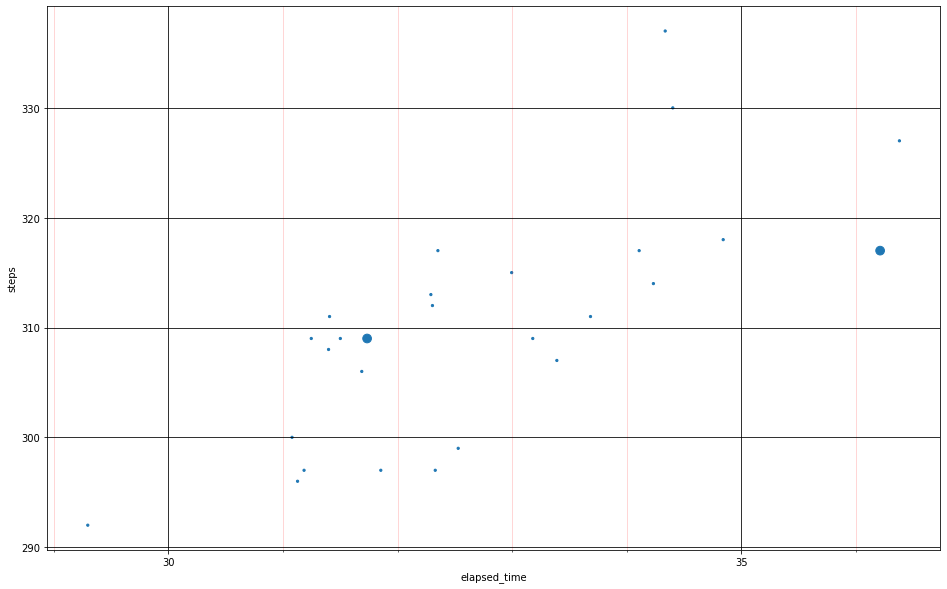

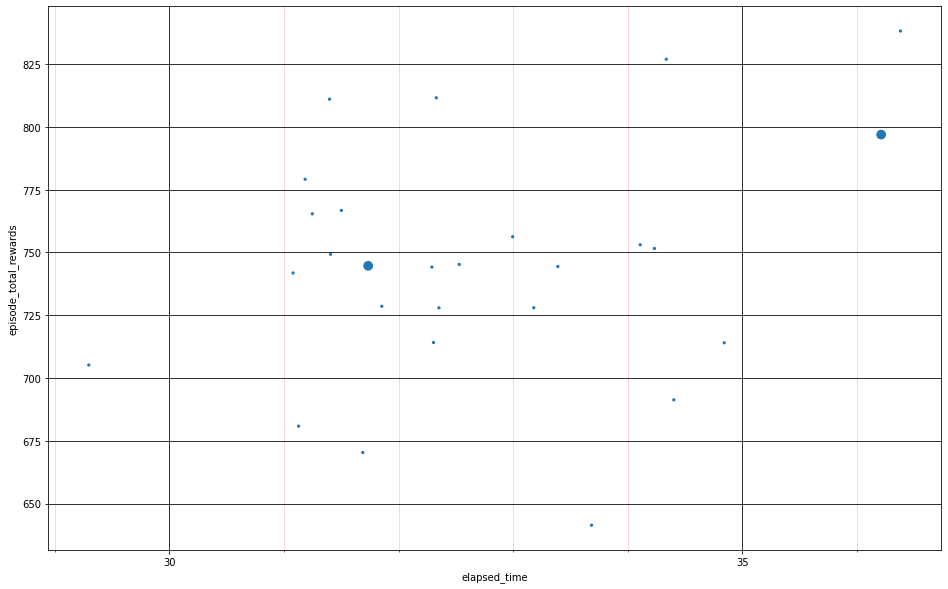

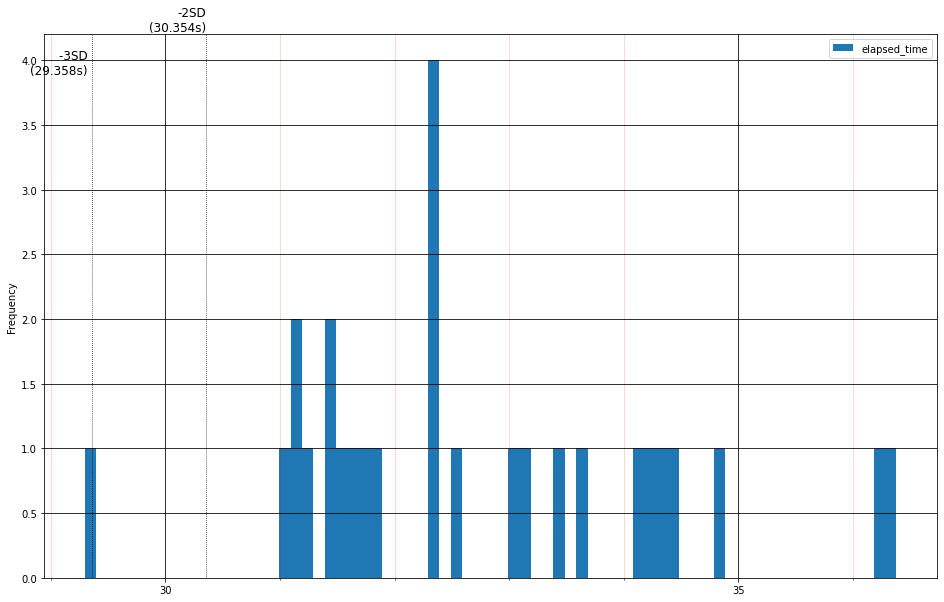

In [25]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
#df_slice = df_slice[df_slice['iteration'] <= 56]
max_iteration = df_slice['iteration'].max()

scatter_size = list()
for iter in df_slice['iteration']:
        if (iter > (max_iteration - 3)):
            scatter_size.append(75)
        else:
            scatter_size.append(5)
    
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='scatter', s=scatter_size, x='elapsed_time', y='steps')
    axes.set_xlabel(axes.get_xlabel(), fontsize=10)
    axes.set_ylabel(axes.get_ylabel(), fontsize=10)
    axes.xaxis.set_major_locator(MultipleLocator(5.0))
    axes.xaxis.set_minor_locator(MultipleLocator(1.0))
    axes.grid(True, which='major', color='black')
    axes.grid(True, which='minor', color='red', alpha=0.2)
    
    axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='scatter', s=scatter_size, x='elapsed_time', y='episode_total_rewards')
    axes.set_xlabel(axes.get_xlabel(), fontsize=10)
    axes.set_ylabel(axes.get_ylabel(), fontsize=10)
    axes.xaxis.set_major_locator(MultipleLocator(5.0))
    axes.xaxis.set_minor_locator(MultipleLocator(1.0))
    axes.grid(True, which='major', color='black')
    axes.grid(True, which='minor', color='red', alpha=0.2)
    
    w = 0.1
    n = math.ceil((df_slice['elapsed_time'].max() - df_slice['elapsed_time'].min())/w)
    if n == 0:
        n = 1
    print(n)
    axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='hist', bins=n, x='steps', y='elapsed_time')
    axes.set_xlabel(axes.get_xlabel(), fontsize=10)
    axes.set_ylabel(axes.get_ylabel(), fontsize=10)
    axes.xaxis.set_major_locator(MultipleLocator(5.0))
    axes.xaxis.set_minor_locator(MultipleLocator(1.0))
    axes.grid(True, which='major', color='black')
    axes.grid(True, which='minor', color='red', alpha=0.2)

    data_minus2sd = np.percentile(df_slice['elapsed_time'], 2.28)
    data_minus3sd = np.percentile(df_slice['elapsed_time'], 0.13)

    print('Mean: %f' % (np.mean(df_slice['elapsed_time'])))
    print('Variance: %f' % (np.var(df_slice['elapsed_time'])))
    print('StdDev: %f' % (np.std(df_slice['elapsed_time'])))
    print('-2 StdDev: %f' % (data_minus2sd))
    print('-3 StdDev: %f' % (data_minus3sd))
    
    axes.axvline(x=data_minus2sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus2sd, axes.get_ylim()[1], '-2SD\n(%0.3fs)' % data_minus2sd, ha='right', va='bottom', size=12)

    axes.axvline(x=data_minus3sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus3sd, axes.get_ylim()[1], '\n-3SD \n(%0.3fs) ' % data_minus3sd, ha='right', va='top', size=12)


# Identify Potential Model Checkpoints for Cloning and Race Submission
- Plot the top quartile (p25) lap times vs iterations to identify potential model checkpoints and to look out for trade-offs between speed and stability over time
- Use the mean lap times per iteration among the p25 population to see through the noise
- Find the best lap times among the p25 population as an additional consideration

Completed Episodes: 27
p25: 31.454s
Completed Episodes (p25): 7


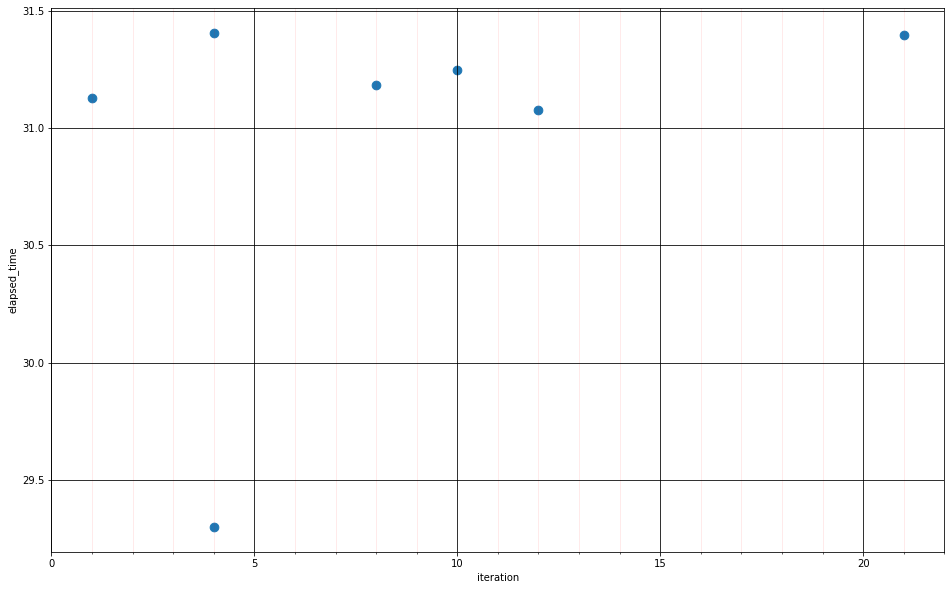

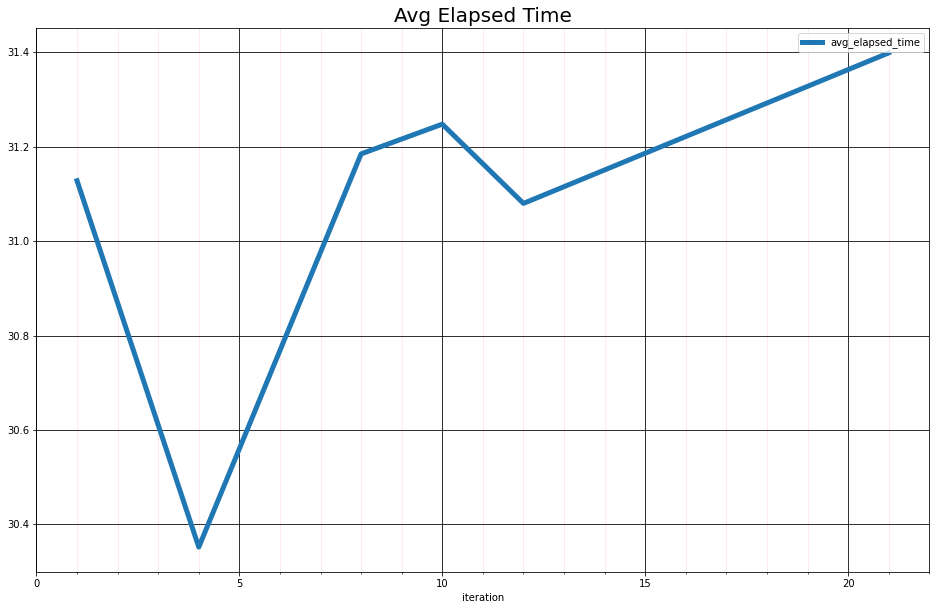

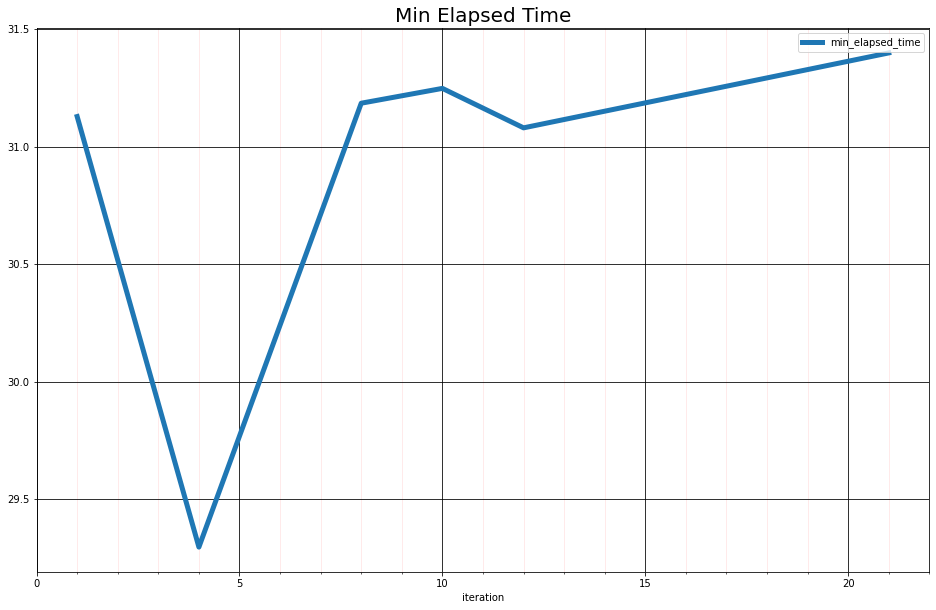

In [26]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    elapsed_time_p25 = df_slice['elapsed_time'].quantile(.25)
    print('p25: %.3fs' % elapsed_time_p25)

    df_slice = df_slice[df_slice['elapsed_time'] <= elapsed_time_p25]
    completed_episode_p25_count = df_slice['episode'].count()
    print('Completed Episodes (p25): %d' % completed_episode_p25_count)
    if completed_episode_p25_count > 0:
        axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='scatter', s=75, x='iteration', y='elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=10)
        axes.set_ylabel(axes.get_ylabel(), fontsize=10)
        axes.xaxis.set_major_locator(MultipleLocator(5.0))
        axes.xaxis.set_minor_locator(MultipleLocator(1.0))
        axes.grid(True, which='major', color='black')
        axes.grid(True, which='minor', color='red', alpha=0.1)
        
        df_slice["avg_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("mean")
        df_slice["min_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("min")

        axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='line', linewidth=5, x='iteration', y='avg_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=10)
        axes.set_ylabel(axes.get_ylabel(), fontsize=10)
        axes.xaxis.set_major_locator(MultipleLocator(5.0))
        axes.xaxis.set_minor_locator(MultipleLocator(1.0))
        axes.grid(True, which='major', color='black')
        axes.grid(True, which='minor', color='red', alpha=0.1)
        axes.set_title('Avg Elapsed Time', fontsize=20)
        
        axes = df_slice.plot(figsize=(16,10), fontsize=10, kind='line', linewidth=5, x='iteration', y='min_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=10)
        axes.set_ylabel(axes.get_ylabel(), fontsize=10)
        axes.xaxis.set_major_locator(MultipleLocator(5.0))
        axes.xaxis.set_minor_locator(MultipleLocator(1.0))
        axes.grid(True, which='major', color='black')
        axes.grid(True, which='minor', color='red', alpha=0.1)
        axes.set_title('Min Elapsed Time', fontsize=20)
        

# Plot (Rewards vs Entropy vs Lap Progress) per Iteration

In [27]:
def plot_reward_graph(df_slice_iterations=sim_df_iterations, df_slice_entropy=trn_df_entropy):
    font_size=16
    if(len(df_slice_iterations)>0):
        fig = plt.figure(figsize=(16, 10))
        ax = plt.gca()  # gca stands for 'get current axis'
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        df_slice_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
        df_slice_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

        df_slice_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

        df_slice_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

        ax.legend().remove()
        ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
        ax.set_ylabel('Entropy', fontsize=font_size)

        ax2.legend().remove()
        ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

        start_time = df_slice_iterations["start_time"].min()
        end_time = df_slice_iterations["end_time"].max()
        elapsed_time = end_time - start_time
        elapsed_time_hrs = elapsed_time / 3600
        plt.plot([], [], ' ', label='Iterations: %d' % df_slice_iterations["iteration"].max())
        plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

        fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=14, title="Legend")
        plt.subplots_adjust(bottom=0.15)

        max_rewards_iter = df_slice_iterations['total_rewards_normalized_SMA3'].idxmax()
        if (max_rewards_iter >= 0):
            xmax_rewards = df_slice_iterations['iteration'][max_rewards_iter]
            ymax_rewards = df_slice_iterations['total_rewards_normalized_SMA3'].max()
            plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

        max_progress_iter = df_slice_iterations['avg_progress_SMA3'].idxmax()
        if (max_progress_iter >= 0):
            xmax_progress = df_slice_iterations['iteration'][max_progress_iter]
            ymax_progress = df_slice_iterations['avg_progress_SMA3'].max()
            plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

        plt.yticks(np.arange(0, 105, step=10))
        plt.show()
        if (max_rewards_iter >= 0):
            print ("Iteration with Max Total Rewards (SMA3): %d" % (xmax_rewards))
        print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))

# Plot Entropy vs Rewards/Progress as an Additional Indicator for Convergence
- Uses the SMA3 aggregate data to smoothen the graph plot

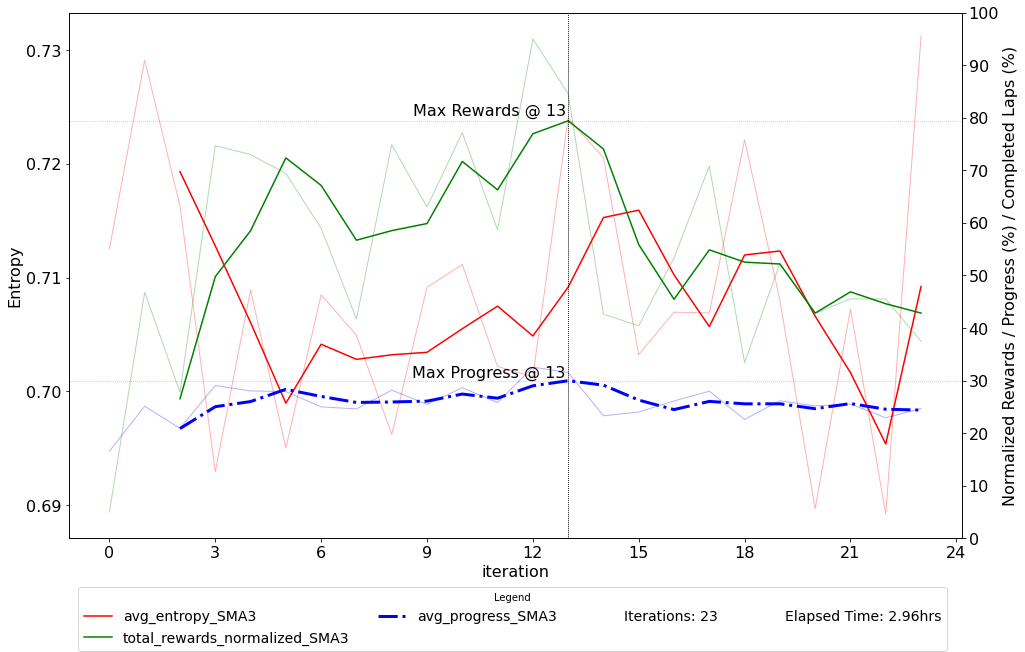

Iteration with Max Total Rewards (SMA3): 13
Elapsed Time: 10663.74s (2.96hrs)


In [28]:
plot_reward_graph()

# Plot the Lap-Completion Ratio of Episodes in Each Iteration to Gauge the Consistency of the Model
- Uses the SMA3 aggregate data to smoothen the graph plot

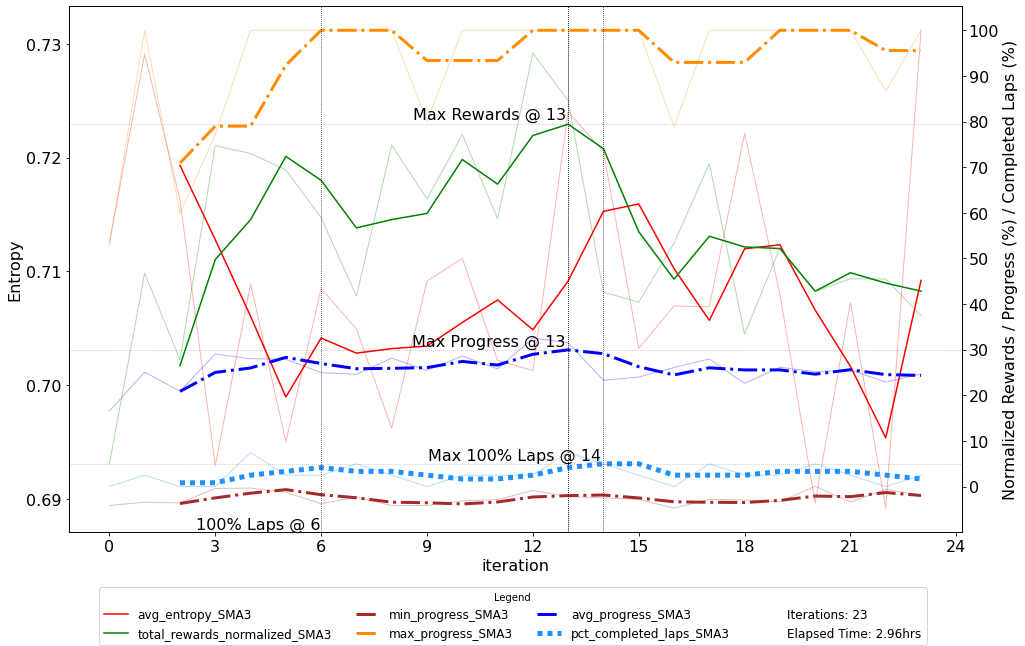

Iteration with First Completed Laps (SMA3): 6
Iteration with Max Pct Completed Laps (SMA3): 14 (Value 5.0)
Iteration with Max Total Rewards (SMA3): 13
Elapsed Time: 10663.74s (2.96hrs)


In [29]:
font_size=16
if(len(sim_df_iterations)>0):
    fig = plt.figure(figsize=(16, 10))
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    trn_df_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
    trn_df_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

    sim_df_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='min_progress',label='',linewidth=1,color='brown',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='min_progress_SMA3',linewidth=3,color='brown',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='max_progress',label='',linewidth=1,color='darkorange',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='max_progress_SMA3',linewidth=3,color='darkorange',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='pct_completed_laps',label='',linewidth=1,color='dodgerblue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA3',linewidth=5,color='dodgerblue',fontsize=font_size,ax=ax2)

    ax.legend().remove()
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_ylabel('Entropy', fontsize=font_size)
    ax2.legend().remove()
    ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

    start_time = sim_df_iterations["start_time"].min()
    end_time = sim_df_iterations["end_time"].max()
    elapsed_time = end_time - start_time
    elapsed_time_hrs = elapsed_time / 3600
    plt.plot([], [], ' ', label='Iterations: %d' % sim_df_iterations["iteration"].max())
    plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

    fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=12, title="Legend")
    plt.subplots_adjust(bottom=0.15)

    first_100pct_iteration = sim_df_iterations[sim_df_iterations["max_progress_SMA3"] >= 100.0]['iteration'].min()
    if first_100pct_iteration > 0:
        plt.axvline(x=first_100pct_iteration,linestyle='dotted',linewidth=0.75,color='black')
        plt.gca().text(first_100pct_iteration*0.995, ax2.get_ylim()[0], '100%% Laps @ %d' % first_100pct_iteration, ha='right', va='bottom', size=font_size)

    max_rewards_iter = sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()
    if (max_rewards_iter >= 0):
        xmax_rewards = sim_df_iterations['iteration'][sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()]
        ymax_rewards = sim_df_iterations['total_rewards_normalized_SMA3'].max()
        plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

    max_progress_iter = sim_df_iterations['avg_progress_SMA3'].idxmax()
    if (max_progress_iter >= 0):
        xmax_progress = sim_df_iterations['iteration'][sim_df_iterations['avg_progress_SMA3'].idxmax()]
        ymax_progress = sim_df_iterations['avg_progress_SMA3'].max()
        plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

    max_completed_iter = sim_df_iterations['pct_completed_laps_SMA3'].idxmax()
    if (max_completed_iter >= 0):
        xmax_completed_laps = sim_df_iterations['iteration'][sim_df_iterations['pct_completed_laps_SMA3'].idxmax()]
        ymax_completed_laps = sim_df_iterations['pct_completed_laps_SMA3'].max()
        plt.axvline(x=xmax_completed_laps,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_completed_laps,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_completed_laps*0.995, ymax_completed_laps*1.005, 'Max 100%% Laps @ %d' % xmax_completed_laps, ha='right', va='bottom', size=font_size)
    
    plt.yticks(np.arange(0, 105, step=10))
    plt.show()

    if (first_100pct_iteration >= 0):
        text= "Iteration with First Completed Laps (SMA3): {:}".format(first_100pct_iteration)
        print(text)

    if (max_completed_iter >= 0):
        text= "Iteration with Max Pct Completed Laps (SMA3): {:} (Value {:})".format(xmax_completed_laps, ymax_completed_laps)
        print(text)

    if (max_rewards_iter >= 0):
        text= "Iteration with Max Total Rewards (SMA3): {:}".format(xmax_rewards)
        print(text)

    print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))


# Load & Visualise the Track Waypoints

If the track is not found, download newer tracks from the [deepracer-simapp bundle](https://github.com/aws-deepracer-community/deepracer-simapp/tree/master/bundle/deepracer_simulation_environment/share/deepracer_simulation_environment/routes) maintained by the community, and copy them into the `tracks` folder

In [30]:
# List the available tracks vs expected WORLD_NAME
print('WORLD_NAME: %s' % WORLD_NAME)
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
ListFiles
print('Available Tracks: %s' % ListFiles)

WORLD_NAME: Monaco_building
Available Tracks: ['AWS_track.npy', 'Albert.npy', 'AmericasGeneratedInclStart.npy', 'Aragon.npy', 'Austin.npy', 'Belille.npy', 'Bowtie_track.npy', 'Canada_Eval.npy', 'Canada_Training.npy', 'ChampionshipCup2019_track.npy', 'China_eval_track.npy', 'China_track.npy', 'FS_June2020.npy', 'H_track.npy', 'July_2020.npy', 'LGSWide.npy', 'London_Loop_Train.npy', 'Mexico_track.npy', 'Mexico_track_eval.npy', 'Monaco.npy', 'New_York_Eval_Track.npy', 'New_York_Track.npy', 'Oval_track.npy', 'Singapore.npy', 'Spain_track.npy', 'Straight_track.npy', 'Tokyo_Training_track.npy', 'Vegas_track.npy', 'Virtual_May19_Train_track.npy', 'reInvent2019_track.npy', 'reInvent2019_wide.npy', 'reInvent2019_wide_mirrored.npy', 'reinvent_base.npy', 'Monaco_building.npy', 'Singapore_building.npy', 'Singapore_f1.npy', 'Spain_track_f1.npy']


In [31]:
fpath = "./racelines/Monaco-1500-4-2020-11-30-215016.npy"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
#racing_track = racing_track.tolist()[:]

In [32]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints(WORLD_NAME)
waypoints.shape

(235, 6)

In [33]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        if i % 5 == 0:
            ax.annotate(i, (p[0], p[1]))
        #else:
            #ax.annotate('*', (p[0], p[1]), color=color)

def plot_line(ax, ob, color):
    ob = LineString(ob)                                                
    x, y = ob.xy                                                                
    ax.plot(x, y, color=color, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2)

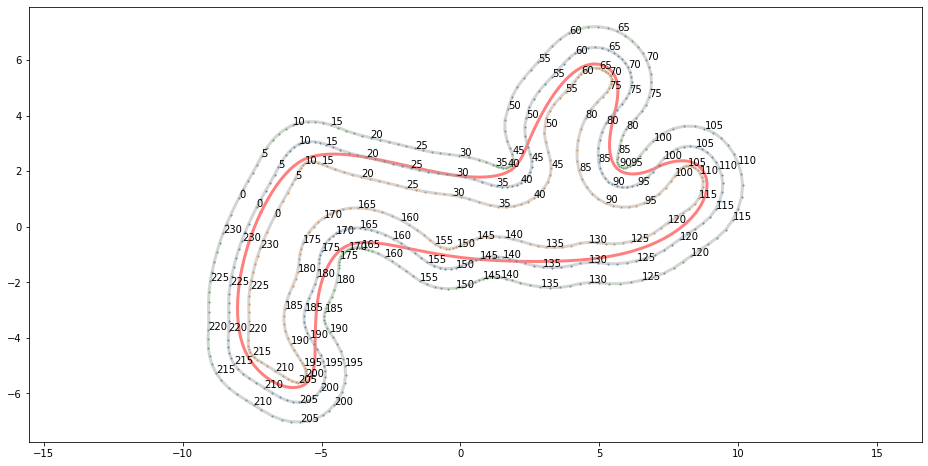

In [34]:
# Plot the results
fig, ax = plt.subplots(figsize=(16,8))


plot_line(ax, racing_track, 'red' )
plot_line(ax, waypoints[:,0:2], '#aaaaaa')
plot_line(ax, waypoints[:,2:4], '#aaaaaa')
plot_line(ax, waypoints[:,4:6], '#aaaaaa')

plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

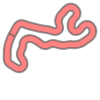

In [35]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

In [36]:
# rescale waypoints to centimeter scale
center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100
racing_track = racing_track[:] *100

In [37]:
# add x_offset to bring everything to the positive axis

x_offset = int(sim_df['x'].min())
if x_offset > 0: # if positive, just keep it the same
    x_offset = 0
x_offset = abs(x_offset)

inner_border[:,:] = inner_border[:,:] + x_offset
center_line[:,:] = center_line[:,:] + x_offset
outer_border[:,:] = outer_border[:,:] + x_offset

racing_track[:,:] = racing_track[:,:] + x_offset

In [38]:
# add y_offset to bring everything to the positive axis

y_offset = int(sim_df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset - x_offset
center_line[:,1] = center_line[:,1] + y_offset - x_offset
outer_border[:,1] = outer_border[:,1] + y_offset - x_offset
racing_track[:,1] = racing_track[:,1] + y_offset - x_offset

In [39]:
# track dimensions
track_x_max = outer_border[:,:].max()
track_y_max = outer_border[:,1].max()
print ('Track Dimensions: (%f, %f)' % (track_x_max, track_y_max))

# simulation dimensions
sim_x_max = sim_df['x'].max() + x_offset
sim_y_max = sim_df['y'].max() + y_offset
print ('Simulation Dimensions: (%f, %f)' % (sim_x_max, sim_y_max))

# plot dimensions
plot_x_max = int(math.ceil(max(track_x_max, sim_x_max)/50) * 50)
plot_y_max = int(math.ceil(max(track_y_max, sim_y_max)/50) * 50)
print ('Plot Dimensions: (%d, %d)' % (plot_x_max, plot_y_max))

Track Dimensions: (1952.939999, 1452.977522)
Simulation Dimensions: (1961.390000, 1457.780000)
Plot Dimensions: (2000, 1500)


In [40]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints, racing_track):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(racing_track)
    plot_coords(ax, line)
    plot_line(ax, line)

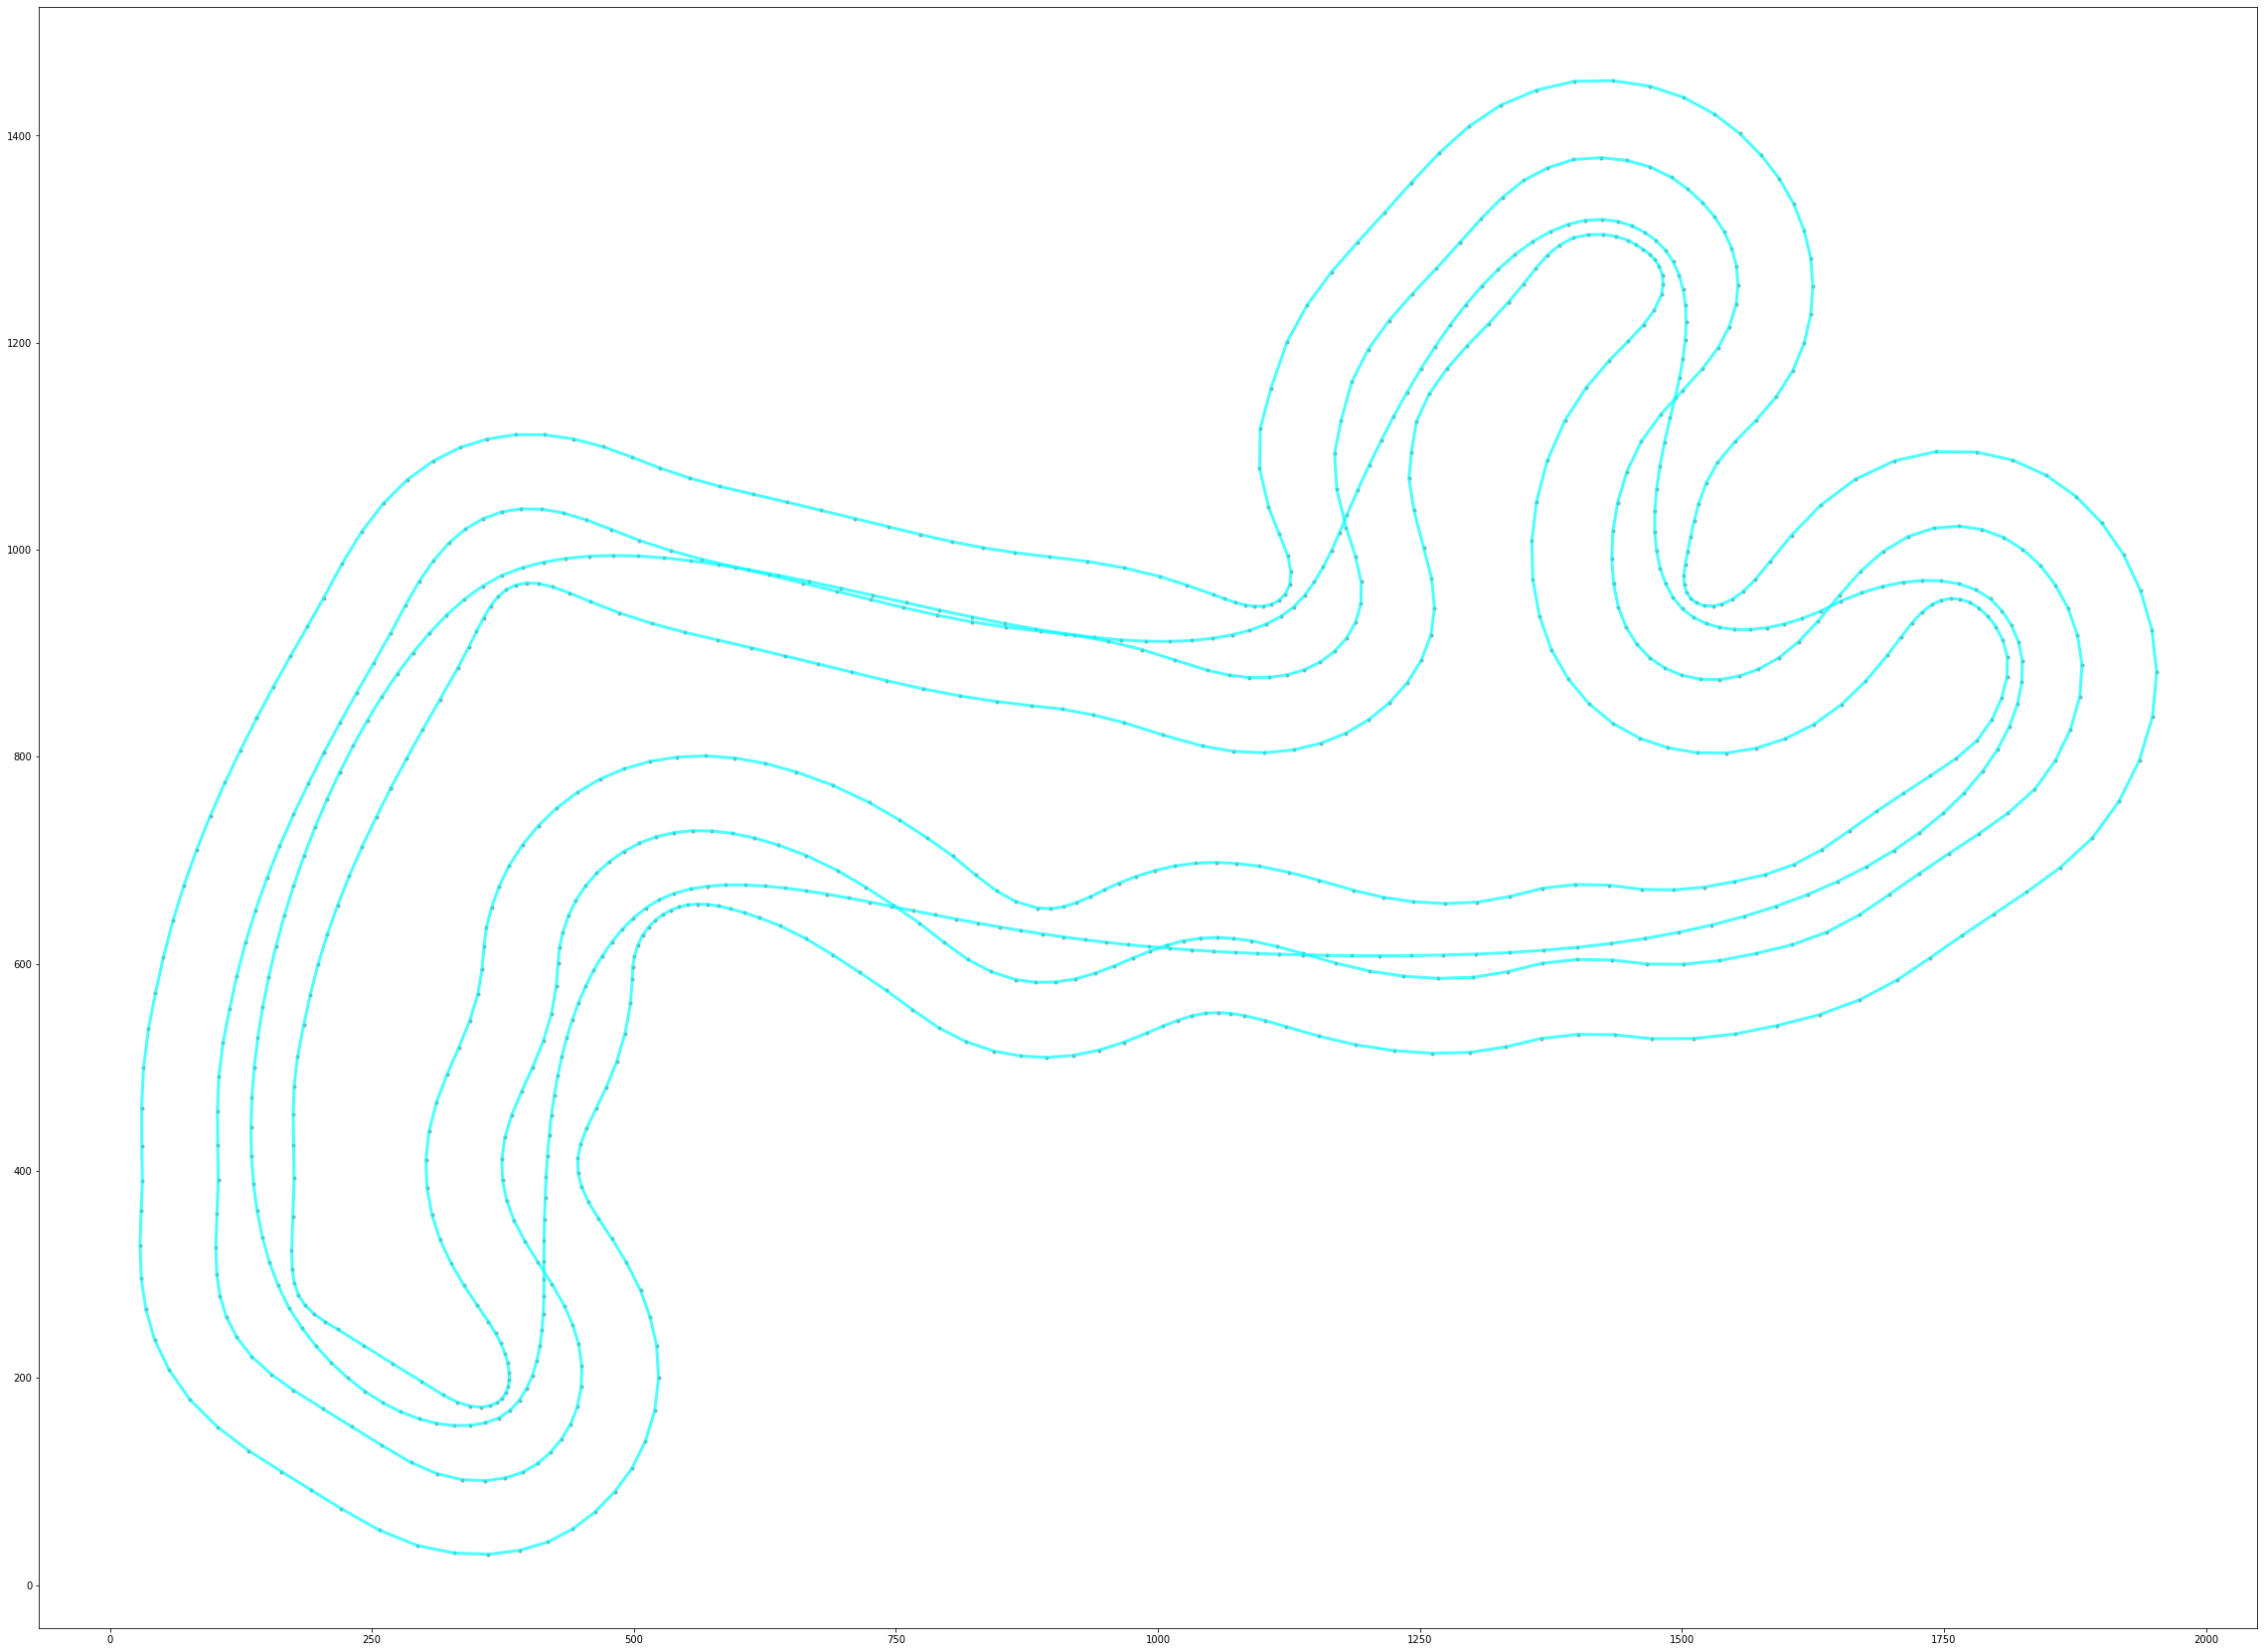

In [41]:
# Plot the track layout with the right scale and size

fig = plt.figure(figsize=(plot_x_max/50, plot_y_max/50))
ax = fig.add_subplot(111)
print_border(ax, center_line, inner_border, outer_border, racing_track)

# Plot Actions Utilisation Heatmap for the Most Recent Iteration to Tweak the Action Space
- Use a heatmap to visualise the relative use of each action in the action space, in order to identify actions to consolidate / remove

In [42]:
def plot_count_on_action(df):
    actionspace = np.zeros((int((action_max_speed+(action_min_speed/3)) * 10 * 1.1), int(action_steering_range * 1.1)))
    for index, row in df.iterrows():
        x = int(row["steer"])+(int(action_steering_range * 1.1 / 2))
        y = int(row["throttle"]*10)
        actionspace[y,x] += 1
        
    fig = plt.figure(1, figsize=(16,10))
    ax = fig.add_subplot(111)
    return actionspace

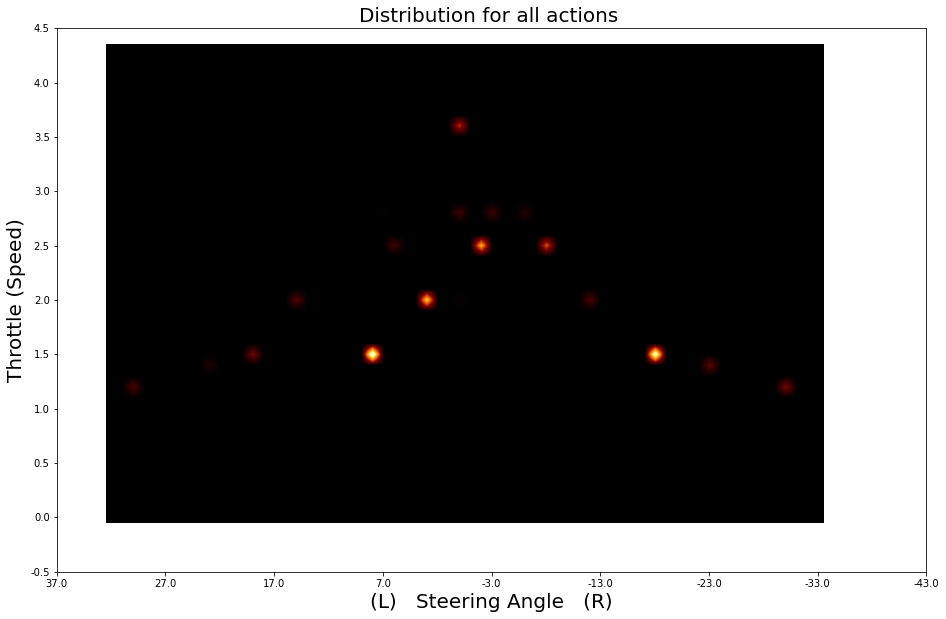

In [43]:
max_iteration = sim_df['iteration'].max()
df_slice = sim_df[sim_df['iteration'] == max_iteration]

track = plot_count_on_action(df_slice)
plt.title("Distribution for all actions ", fontsize=20)
im = plt.imshow(track, cmap='afmhot', interpolation='bilinear', origin="lower") 

ax = plt.gca()  # gca stands for 'get current axis'
ax.set_xlabel('(L)   Steering Angle   (R)', fontsize=20)
ax.set_ylabel('Throttle (Speed)', fontsize=20)

xlabels = ax.get_xticks()
ax.set_xticks(xlabels)
new_xlabels = [(x-int(action_steering_range * 1.1 / 2)) for x in xlabels]
ax.xaxis.set_ticklabels(new_xlabels)
ax.set_xlim(xlabels[-1], xlabels[0])

ylabels = ax.get_yticks()
ax.set_yticks(ylabels)
new_ylabels = [(y/10) for y in ylabels]    
ax.yaxis.set_ticklabels(new_ylabels)

plt.show()

# Plot Avg Speed and Steering at Each Waypoint (Horizontal) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (horizontally), to identify inefficiencies in driving behaviour

In [44]:
def plot_speedsteering_per_waypoint_h(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(25.6, 16))
    
    plt.xticks(np.arange(0, max_waypoint+1, 10.0), fontsize=20)
    plt.xlabel('\nWaypoint', fontsize=20)
    plt.yticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=20)
    plt.ylabel('(L)   Steering Angle   (R)\n\n\n', fontsize=20, rotation=270)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xticks(np.arange(5, max_waypoint+1, 10.0), minor=True)
    ax.tick_params(axis='x', which='major', length=10, direction='inout')
    ax.tick_params(axis='x', which='minor', length=5, direction='in')
    ax.set_ylim(math.floor(-max_steering), math.ceil(max_steering))
    ax.set_yticks(np.arange(math.floor(-max_steering)+1, math.ceil(max_steering)+1, 1.0), minor=True)
    ax.tick_params(axis='y', which='major', length=10, direction='inout')
    ax.tick_params(axis='y', which='minor', length=5, direction='in')


    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('\n\n\nThrottle', fontsize=20, rotation=270)
    ax2.set_ylim(-max_speed, max_speed)
    ax2.set_yticks(np.arange(0, max_speed+0.5, 0.5))
    ax2.set_yticks(np.arange(0.1, max_speed+0.1, 0.1), minor=True)
    ax2.tick_params(axis='y', which='major', length=10, direction='inout', labelsize=20)
    ax2.tick_params(axis='y', which='minor', length=5, direction='in')

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [wp, wp]
            y = [0, avg_steering_angle]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([wp, wp], [0, 0], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [wp, wp]
            y = [-avg_speed, avg_speed]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([wp, wp], [0, 0], marker = 'x', color='red', alpha=0.5, linewidth=1)




max_waypoint: 233


iteration  episode_in_iteration  episode  steps       x       y  \
84013         24                    12      972      1  623.32 -125.60   
84014         24                    12      972      2  622.98 -125.54   
84015         24                    12      972      3  619.24 -126.22   
84016         24                    12      972      4  615.68 -127.02   
84017         24                    12      972      5  603.84 -129.66   
84018         24                    12      972      6  592.20 -132.57   
84019         24                    12      972      7  577.51 -136.24   
84020         24                    12      972      8  562.60 -139.94   
84021         24                    12      972      9  536.42 -146.34   
84022         24                    12      972     10  513.34 -151.68   
84023         24                    12      972     11  483.14 -157.67   
84024         24                    12      972     12  462.68 -160.91   
84025         24                    12      972     13  431.52 -163.73   
84026         24                    12      972     14  402.80 -163.54   
84027         24                    12      972     15  385.43 -162.27   
84028         24                    12      972     16  355.40 -158.29   
84029         24                    12      972     17  320.44 -150.87   
84030         24                    12      972     18  296.50 -144.51   
84031         24                    12      972     19  262.27 -134.42   
84032         24                    12      972     20  228.52 -125.77   
84033         24                    12      972     21  213.85 -122.31   
84034         24                    12      972     22  187.67 -116.28   
84035         24                    12      972     23  164.84 -112.08   
84036         24                    12      972     24  146.47 -110.37   
84037         24                    12      972     25  131.53 -110.02   
84038         24                    12      972     26  108.79 -110.82   
84039         24                    12      972     27   95.94 -111.90   
84040         24                    12      972     28   71.07 -115.53   
84041         24                    12      972     29   53.54 -119.46   
84042         24                    12      972     30   38.04 -123.96   
84043         24                    12      972     31   11.40 -132.76   
84044         24                    12      972     32   -9.51 -139.36   
84045         24                    12      972     33  -34.11 -144.84   
84046         24                    12      972     34  -56.50 -146.75   
84047         24                    12      972     35  -75.19 -146.36   
84048         24                    12      972     36  -95.64 -143.29   
84049         24                    12      972     37 -111.50 -139.04   
84050         24                    12      972     38 -127.60 -133.12   
84051         24                    12      972     39 -141.82 -126.05   
84052         24                    12      972     40 -159.42 -114.55   
84053         24                    12      972     41 -174.63 -102.07   
84054         24                    12      972     42 -190.70  -86.68   
84055         24                    12      972     43 -204.90  -72.39   
84056         24                    12      972     44 -219.37  -58.85   
84057         24                    12      972     45 -231.38  -48.68   
84058         24                    12      972     46 -243.63  -39.33   
84059         24                    12      972     47 -258.91  -30.46   
84060         24                    12      972     48 -279.56  -21.56   
84061         24                    12      972     49 -299.03  -15.97   
84062         24                    12      972     50 -319.37  -13.86   
84063         24                    12      972     51 -332.84  -14.88   
84064         24                    12      972     52 -346.65  -17.66   
84065         24                    12      972     53 -359.55  -21.65   
84066      

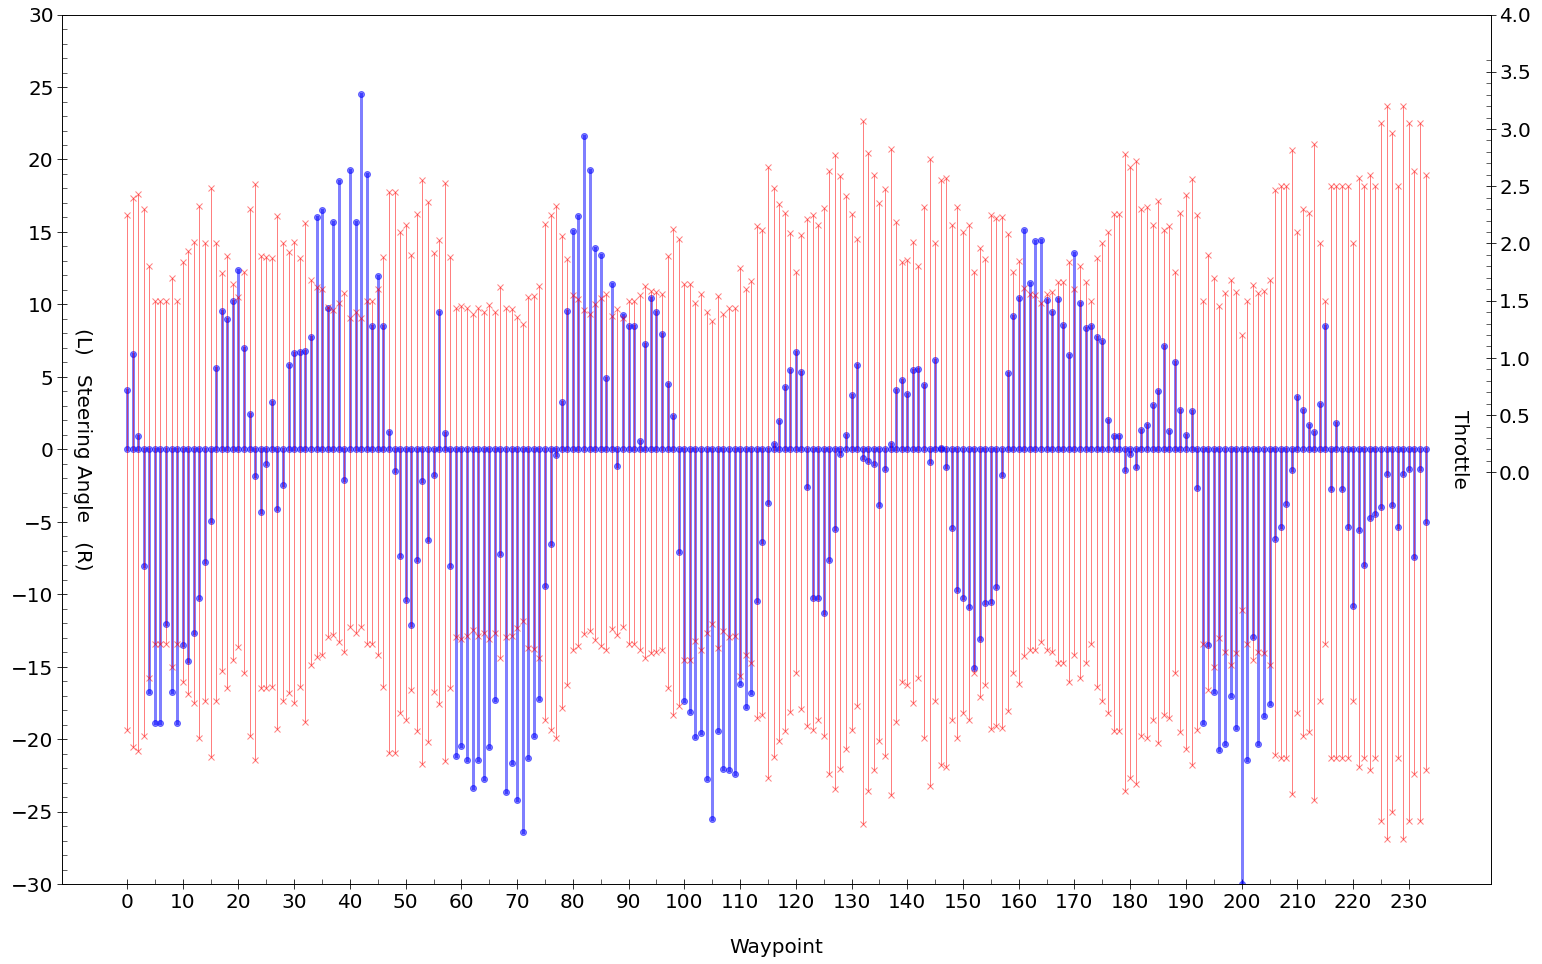

In [45]:
max_iteration = sim_df['iteration'].max()
max_episode = sim_df['episode'].max()
plot_speedsteering_per_waypoint_h(sim_df[sim_df['iteration']==max_iteration])
sim_df[sim_df['episode']==max_episode]
#plot_speedsteering_per_waypoint_h(sim_df[sim_df['episode']==21])
#sim_df[sim_df['episode']==21]

# Plot Avg Speed and Steering at Each Waypoint (Vertical) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (vertically), to identify inefficiencies in driving behaviour

In [46]:
def plot_speedsteering_per_waypoint_v(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(16, max_waypoint/10))
    
    plt.yticks(np.arange(0, max_waypoint+1, 5.0), fontsize=12)
    plt.ylabel('Waypoint\n', fontsize=20)
    plt.xticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=12)
    plt.xlabel('\n(L)   Steering Angle   (R)', fontsize=20)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xlim(math.ceil(max_steering), math.floor(-max_steering))

    ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
    ax2.set_xlabel('Throttle\n', fontsize=20)
    ax2.set_xlim(-max_speed, max_speed)
    ax2.set_xticks(np.arange(0, max_speed+0.5, 0.5))

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [0, avg_steering_angle]
            y = [wp, wp]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([0, 0], [wp, wp], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [-avg_speed, avg_speed]
            y = [wp, wp]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([0, 0], [wp, wp], marker = 'x', color='red', alpha=0.5, linewidth=1)



max_waypoint: 233


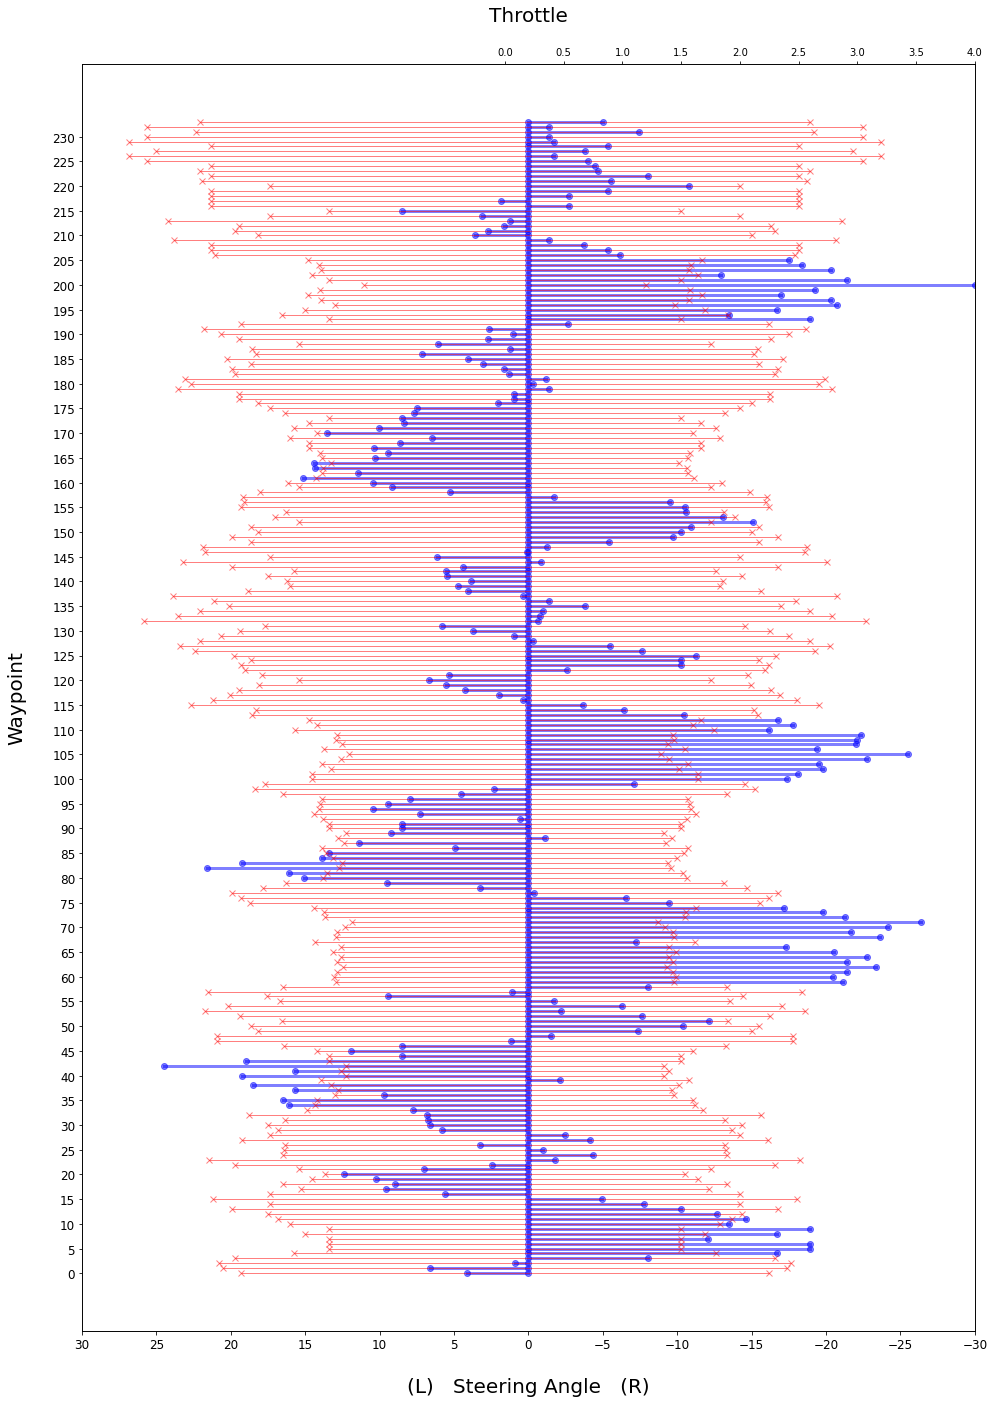

In [47]:
max_iteration = sim_df['iteration'].max()
plot_speedsteering_per_waypoint_v(sim_df[sim_df['iteration']==max_iteration])

# Plot Action / Reward Distribution Heatmap on Track

In [48]:
def plot_x_top_speed_y_top_angle_on_track(df, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''

    x_highest_speed = 0.0
    if speed_index != 0:
        action_speed_list = action_speed
        action_speed_list.sort()
        x_highest_speed = action_speed_list[-speed_index]
        print('Speed - X Highest: X=%d (%f)' % (speed_index, x_highest_speed))

    y_highest_angle = 0.0
    if angle_index != 0:
        action_steering_list = action_steering
        action_steering_list.sort()
        y_highest_angle = action_steering_list[-angle_index]
        print('Absolute Angle - Y Highest: Y=%d (%f)' % (angle_index, y_highest_angle))
    
    if less_equal_angle >= 0:
        print('Absolute Angle - Less Or Equal: %d' % (less_equal_angle))
        
    if exact_angle != 0:
        print('Absolute Angle - Exact: %d' % (exact_angle))        

    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        throttle = row["throttle"]
        steer = row["steer"]
        
        if ((throttle == x_highest_speed) or (speed_index == 0)) and ((abs(steer) == y_highest_angle) or (angle_index == 0)) and ((abs(steer) <= less_equal_angle) or (less_equal_angle < 0)) and ((abs(steer) == exact_angle) or (exact_angle == 0)):
            if (plot_reward == True):
                track[y,x] = reward
            else:
                track[y,x] = 1
        
    fig = plt.figure(1, figsize=(plot_x_max/50, plot_y_max/50))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border, racing_track)
    return track

In [49]:
def plot_x_top_speed_y_top_angle_on_track_for_iteration(curr_iteration, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward):
    max_iteration = sim_df['iteration'].max()
    if (curr_iteration == 0):
        curr_iteration = max_iteration
    df_slice = sim_df[sim_df['iteration']<=curr_iteration]
    df_slice = df_slice[df_slice['iteration']>(curr_iteration-5)]

    track = plot_x_top_speed_y_top_angle_on_track(df_slice, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(plot_y_max, plot_x_max), x_offset=x_offset, y_offset=y_offset)
    title_prefix = ''
    if (plot_reward == True):
        title_prefix = 'Reward '
    plt.title("%sDistribution for X Highest Speed & Y Highest Angle\nAngle Less or Eq to Z & Eq to W\nX: %d / Y: %d / Z: %d / W: %d" % (title_prefix, speed_index, angle_index, less_equal_angle, exact_angle))
    im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Plot Reward Distribution Heatmap on Track for the Most Recent Iteration
- Verify that we're not rewarding for bad driving behaviour
- Overlay a heatmap of rewards on the track to identify areas of improvement for the Reward Function; this could also highlight sections where the car is over- and under-steering, or where the car is not driving smoothly

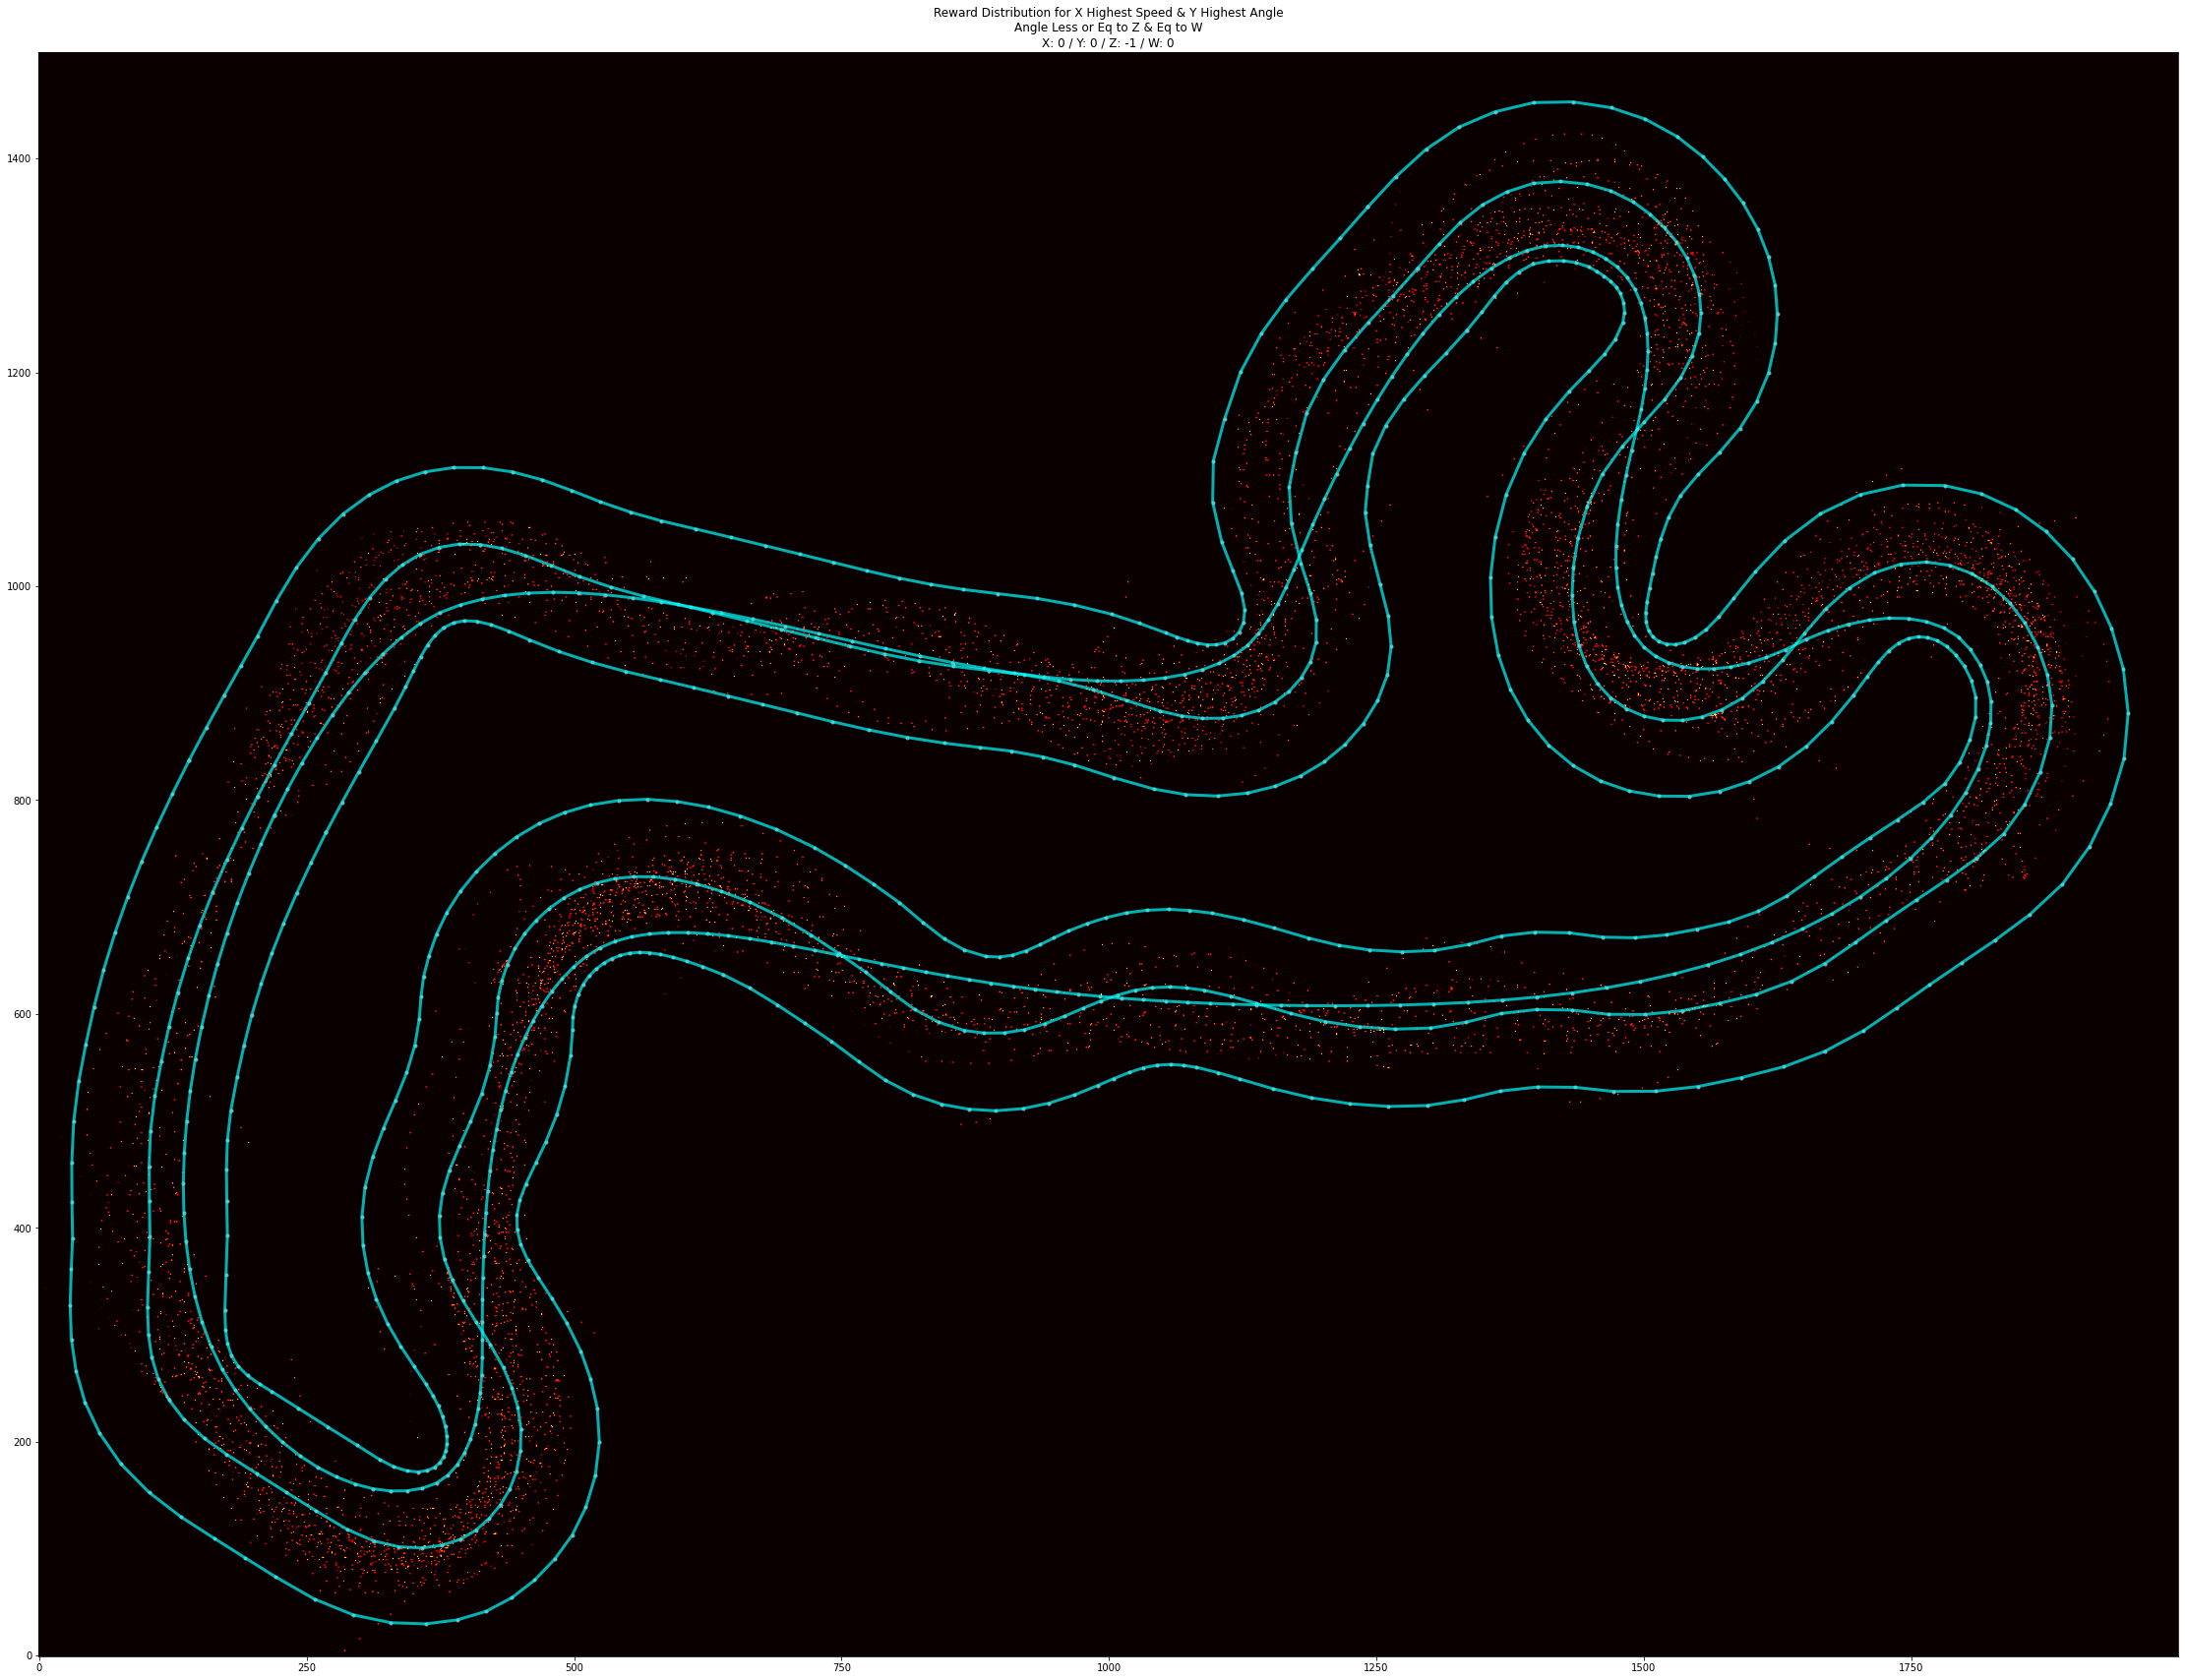

In [50]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, -1, 0, True)

# Plot Highest-Speed Action Distribution Heatmap on Track for the Most Recent Iteration
- Verify that the model uses the highest speed at appropriate sections of the track (eg., on straights)

Speed - X Highest: X=1 (3.600000)


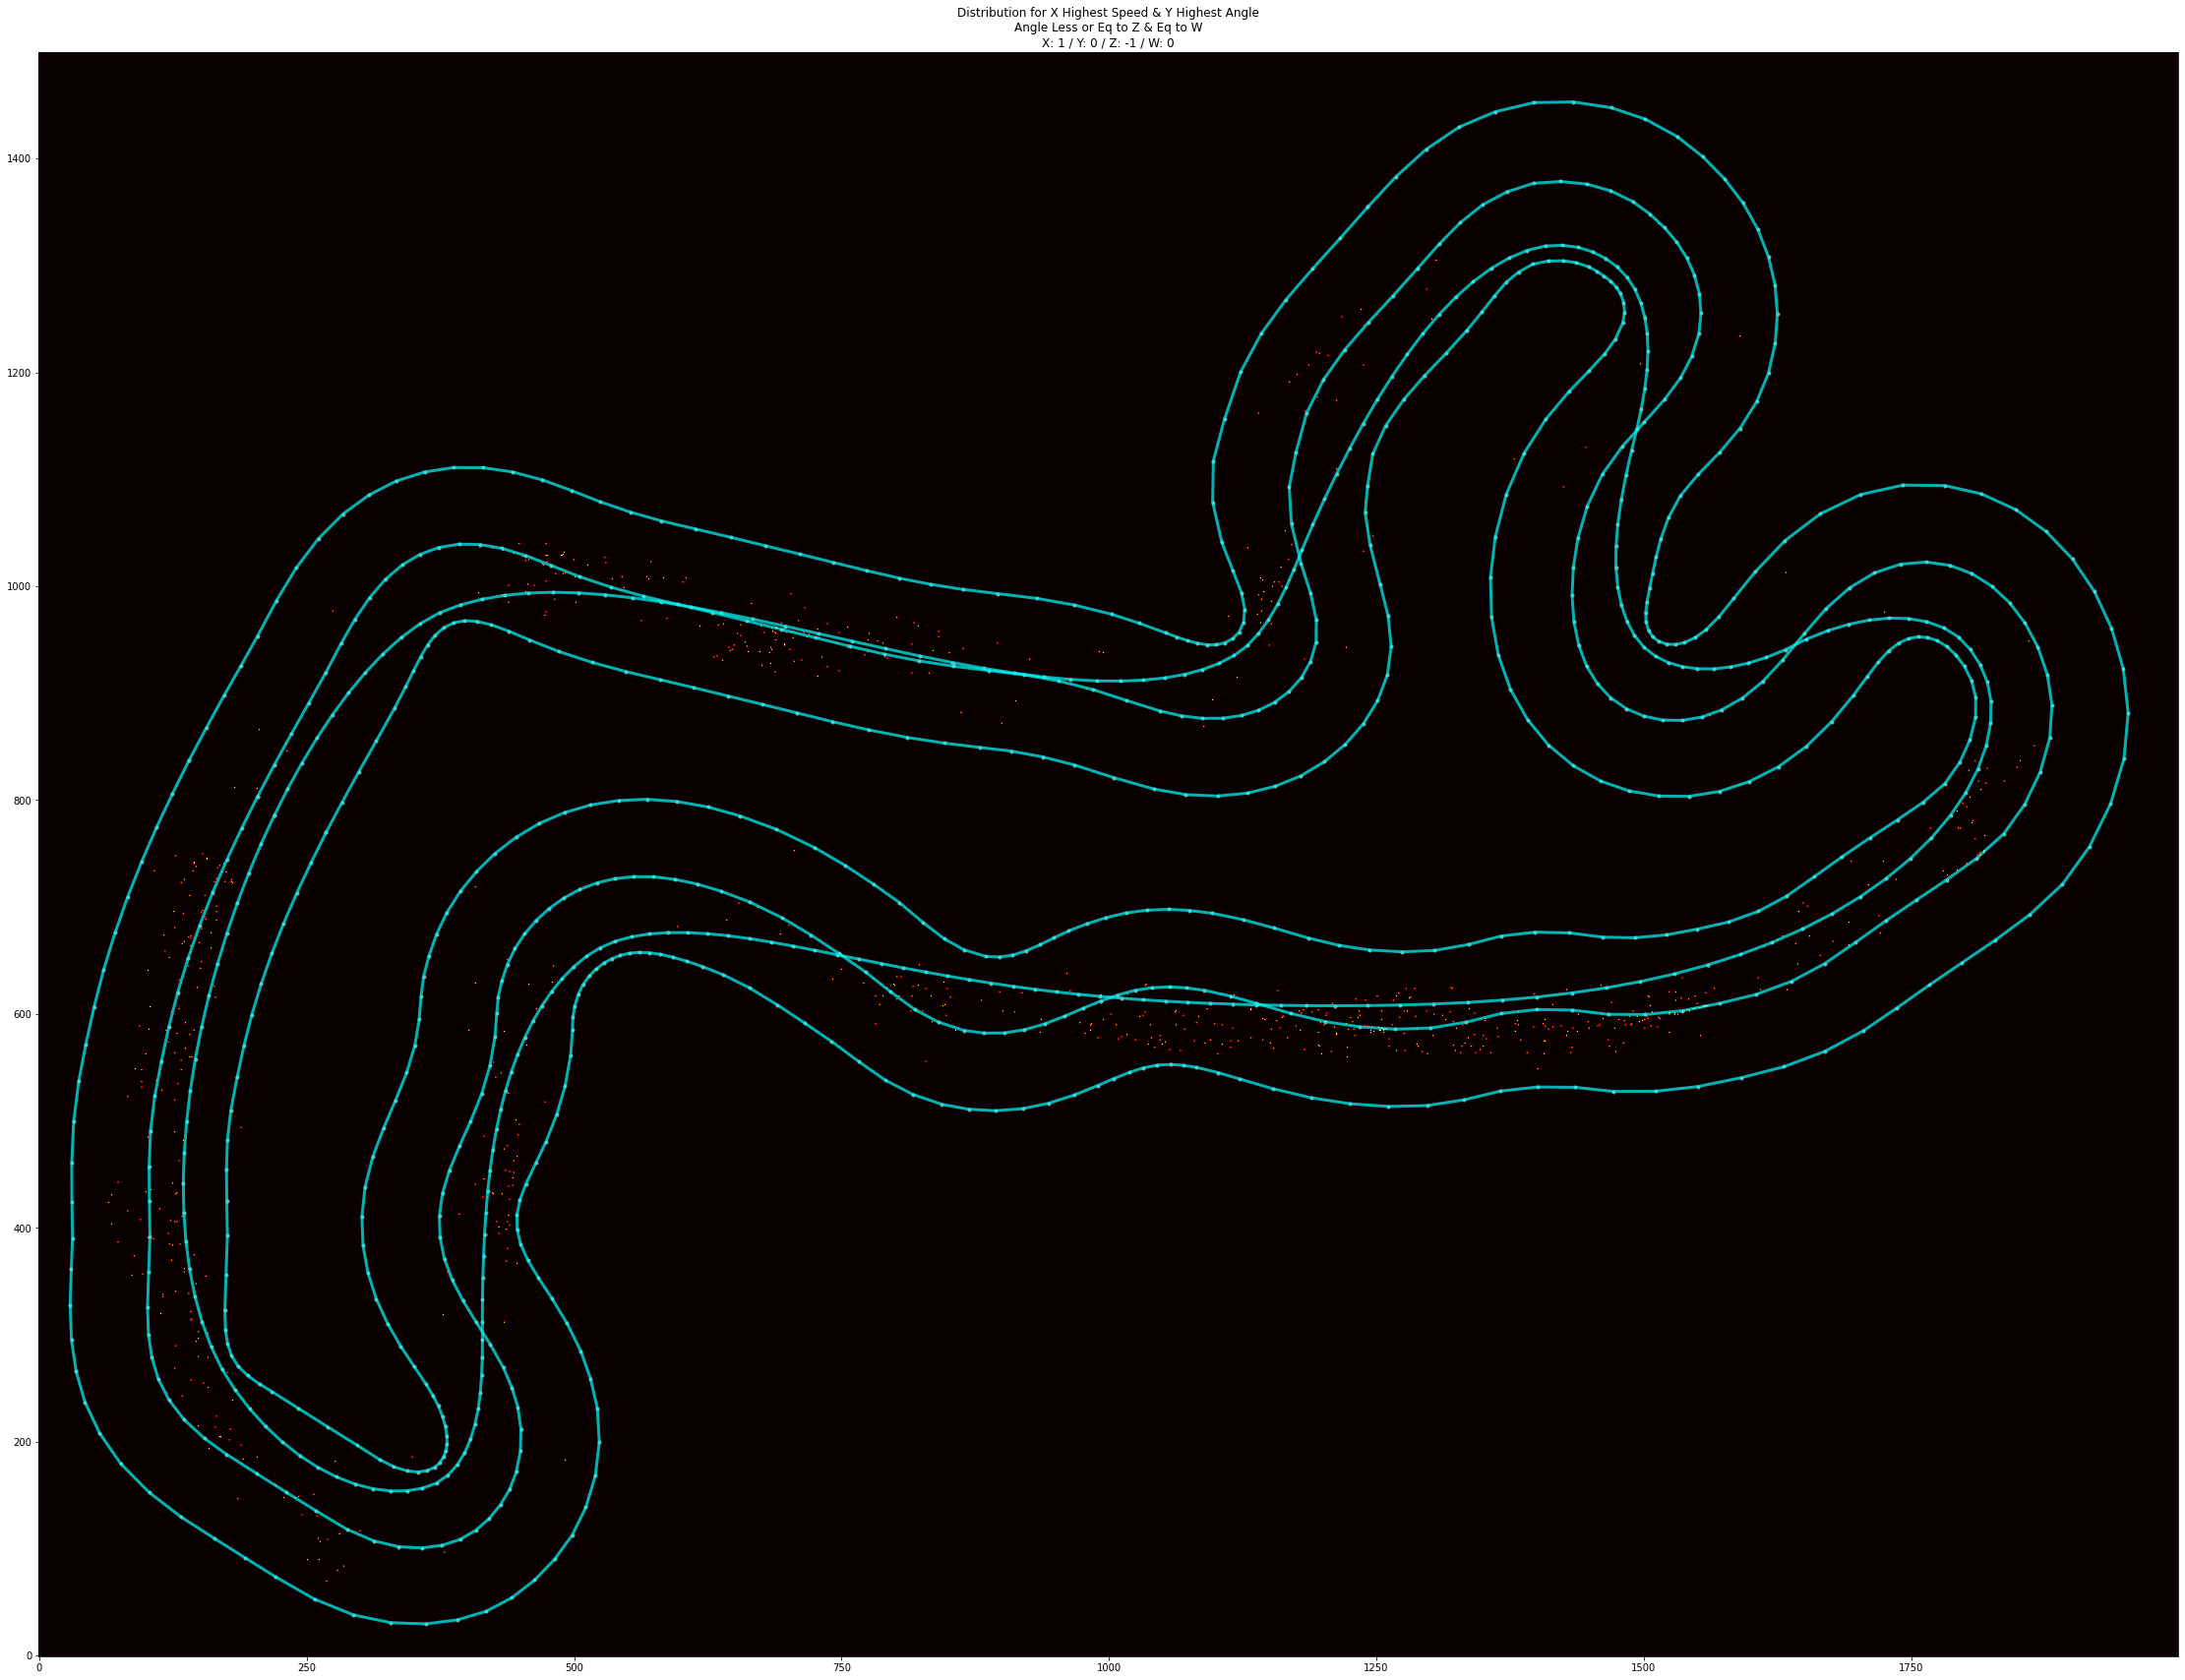

In [51]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 1, 0, -1, 0, False)

# Plot 0-Degree Steering Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is driving straight, to identify sections where we could potentially tweak the actions / rewards

Absolute Angle - Less Or Equal: 0


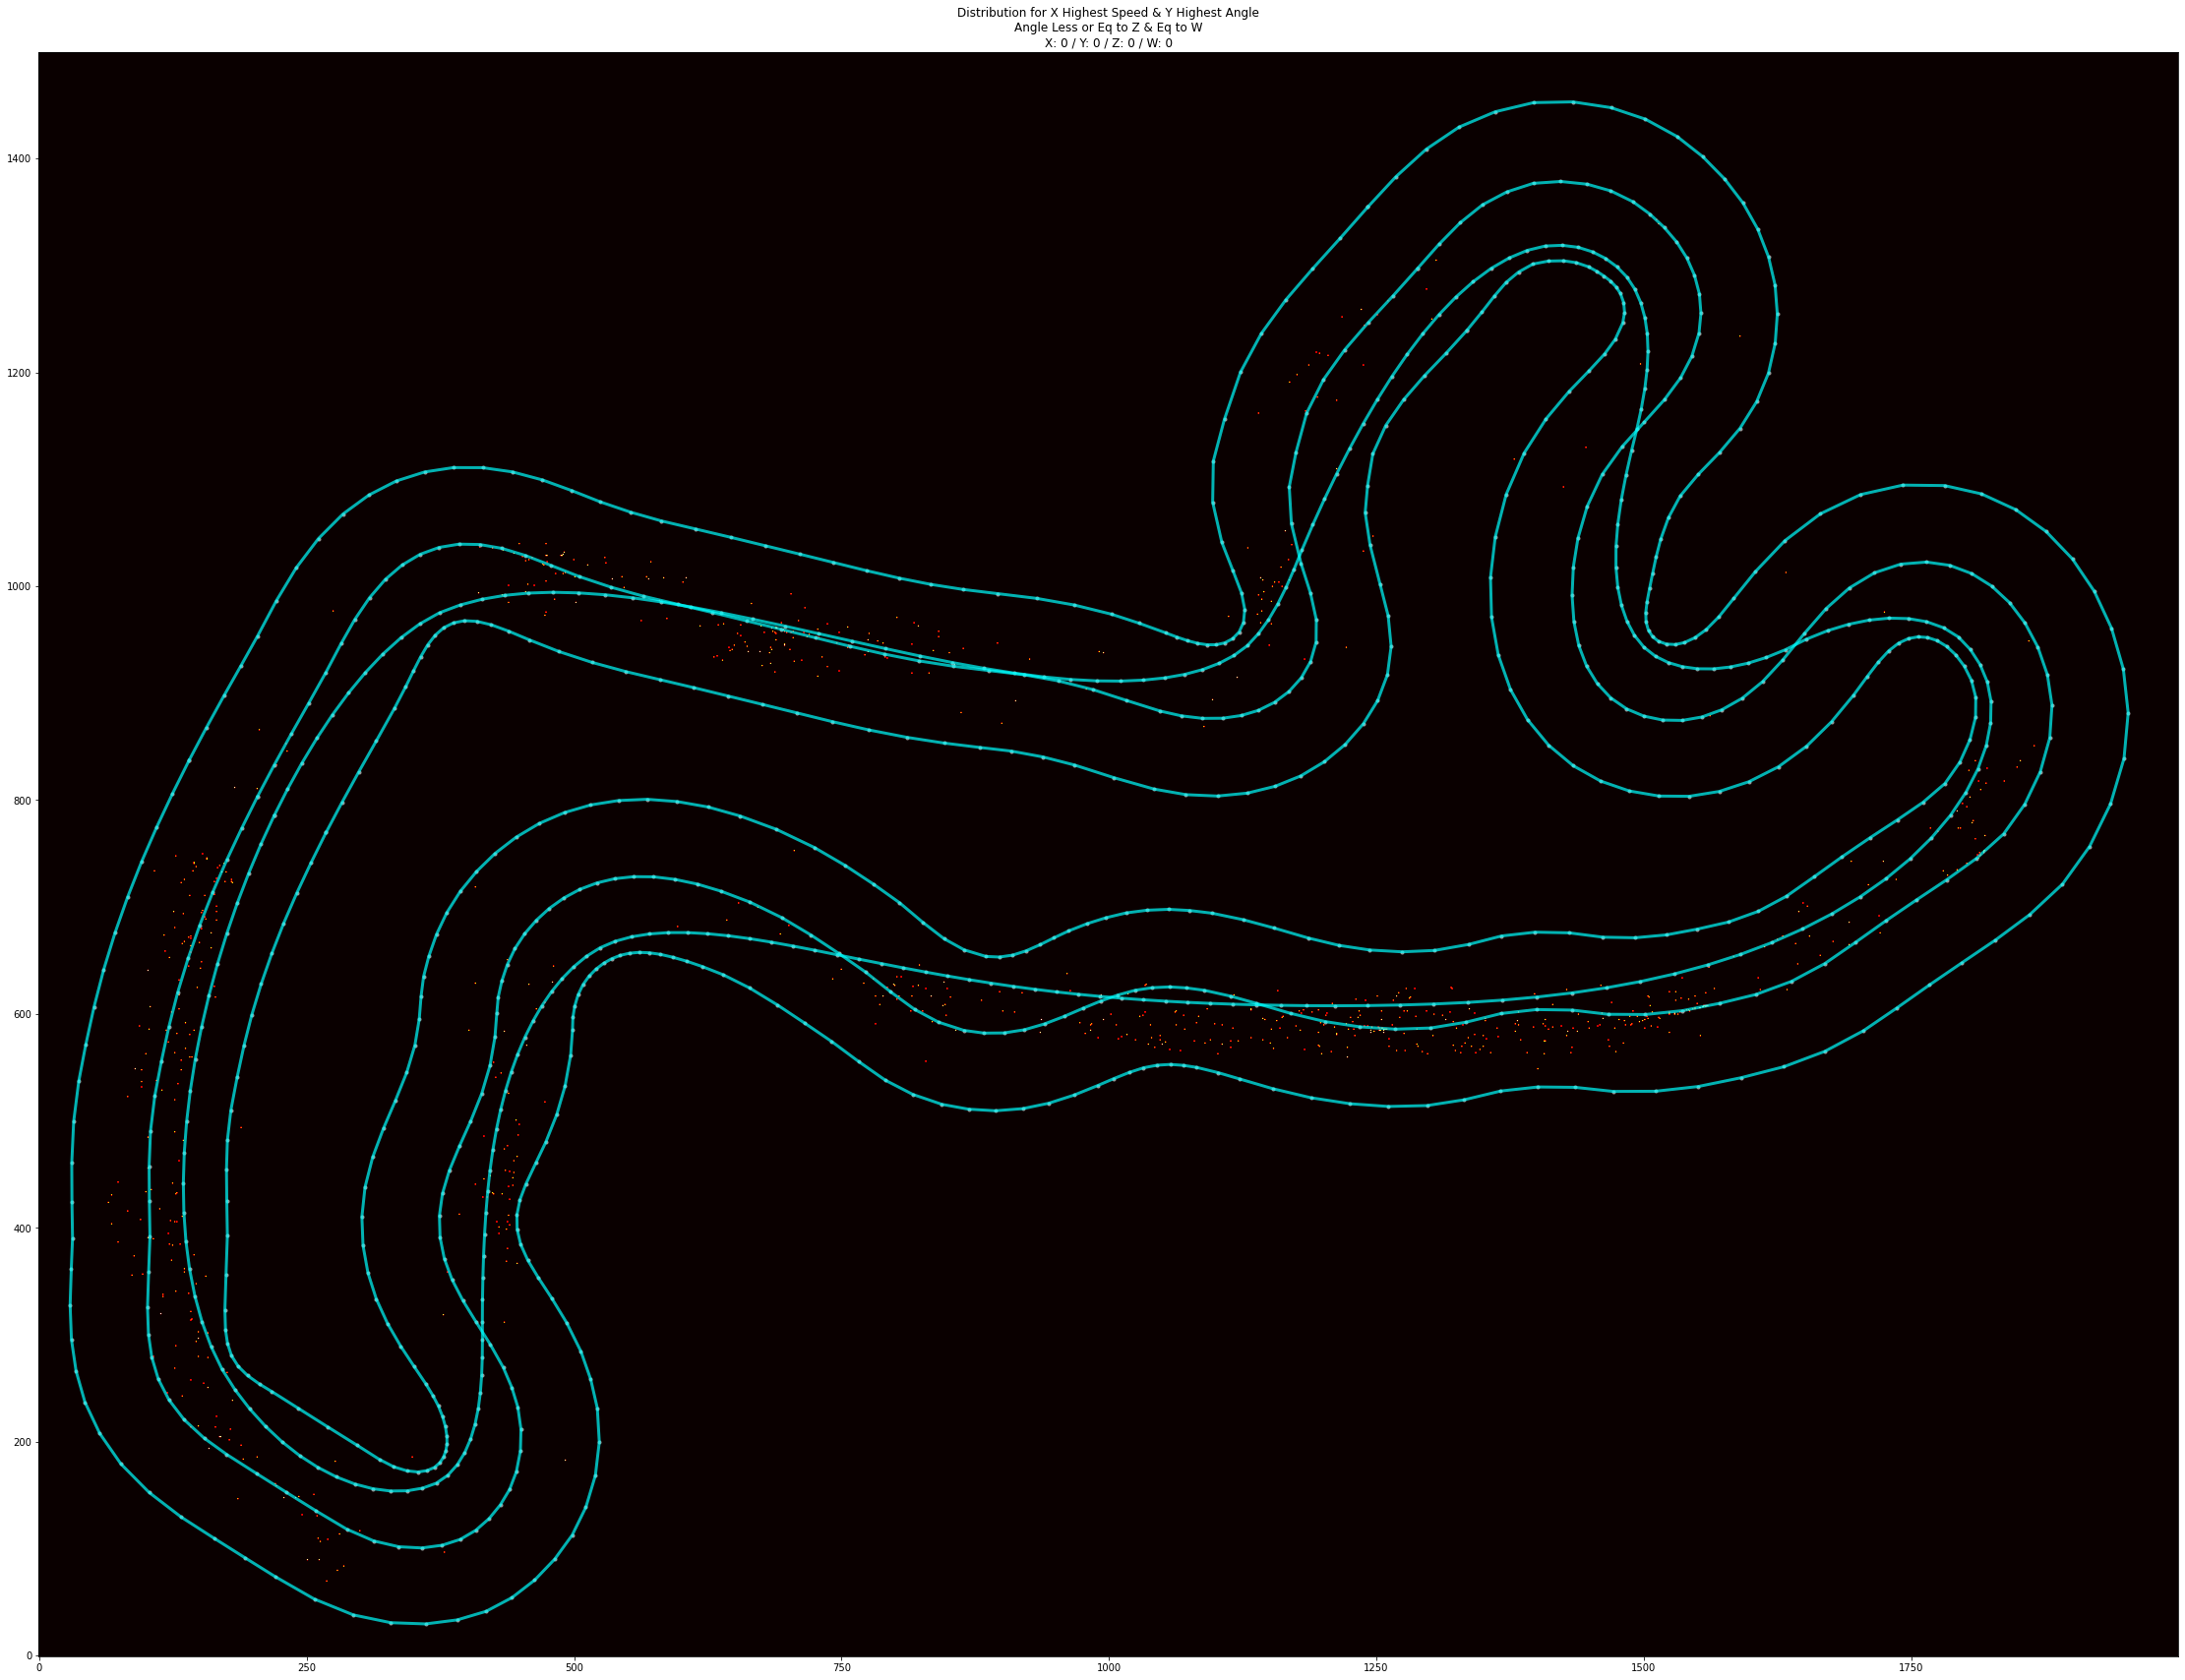

In [52]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, 0, 0, False)

# Plot Widest Steering-Angle Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is steering heavily, to identify sections where we could potentially tweak the actions / rewards
- Assumes there are symmetrical -ve and +ve steering angles (otherwise this would plot only the side that has the biggest absolute steering angle value)

Absolute Angle - Y Highest: Y=1 (30.000000)


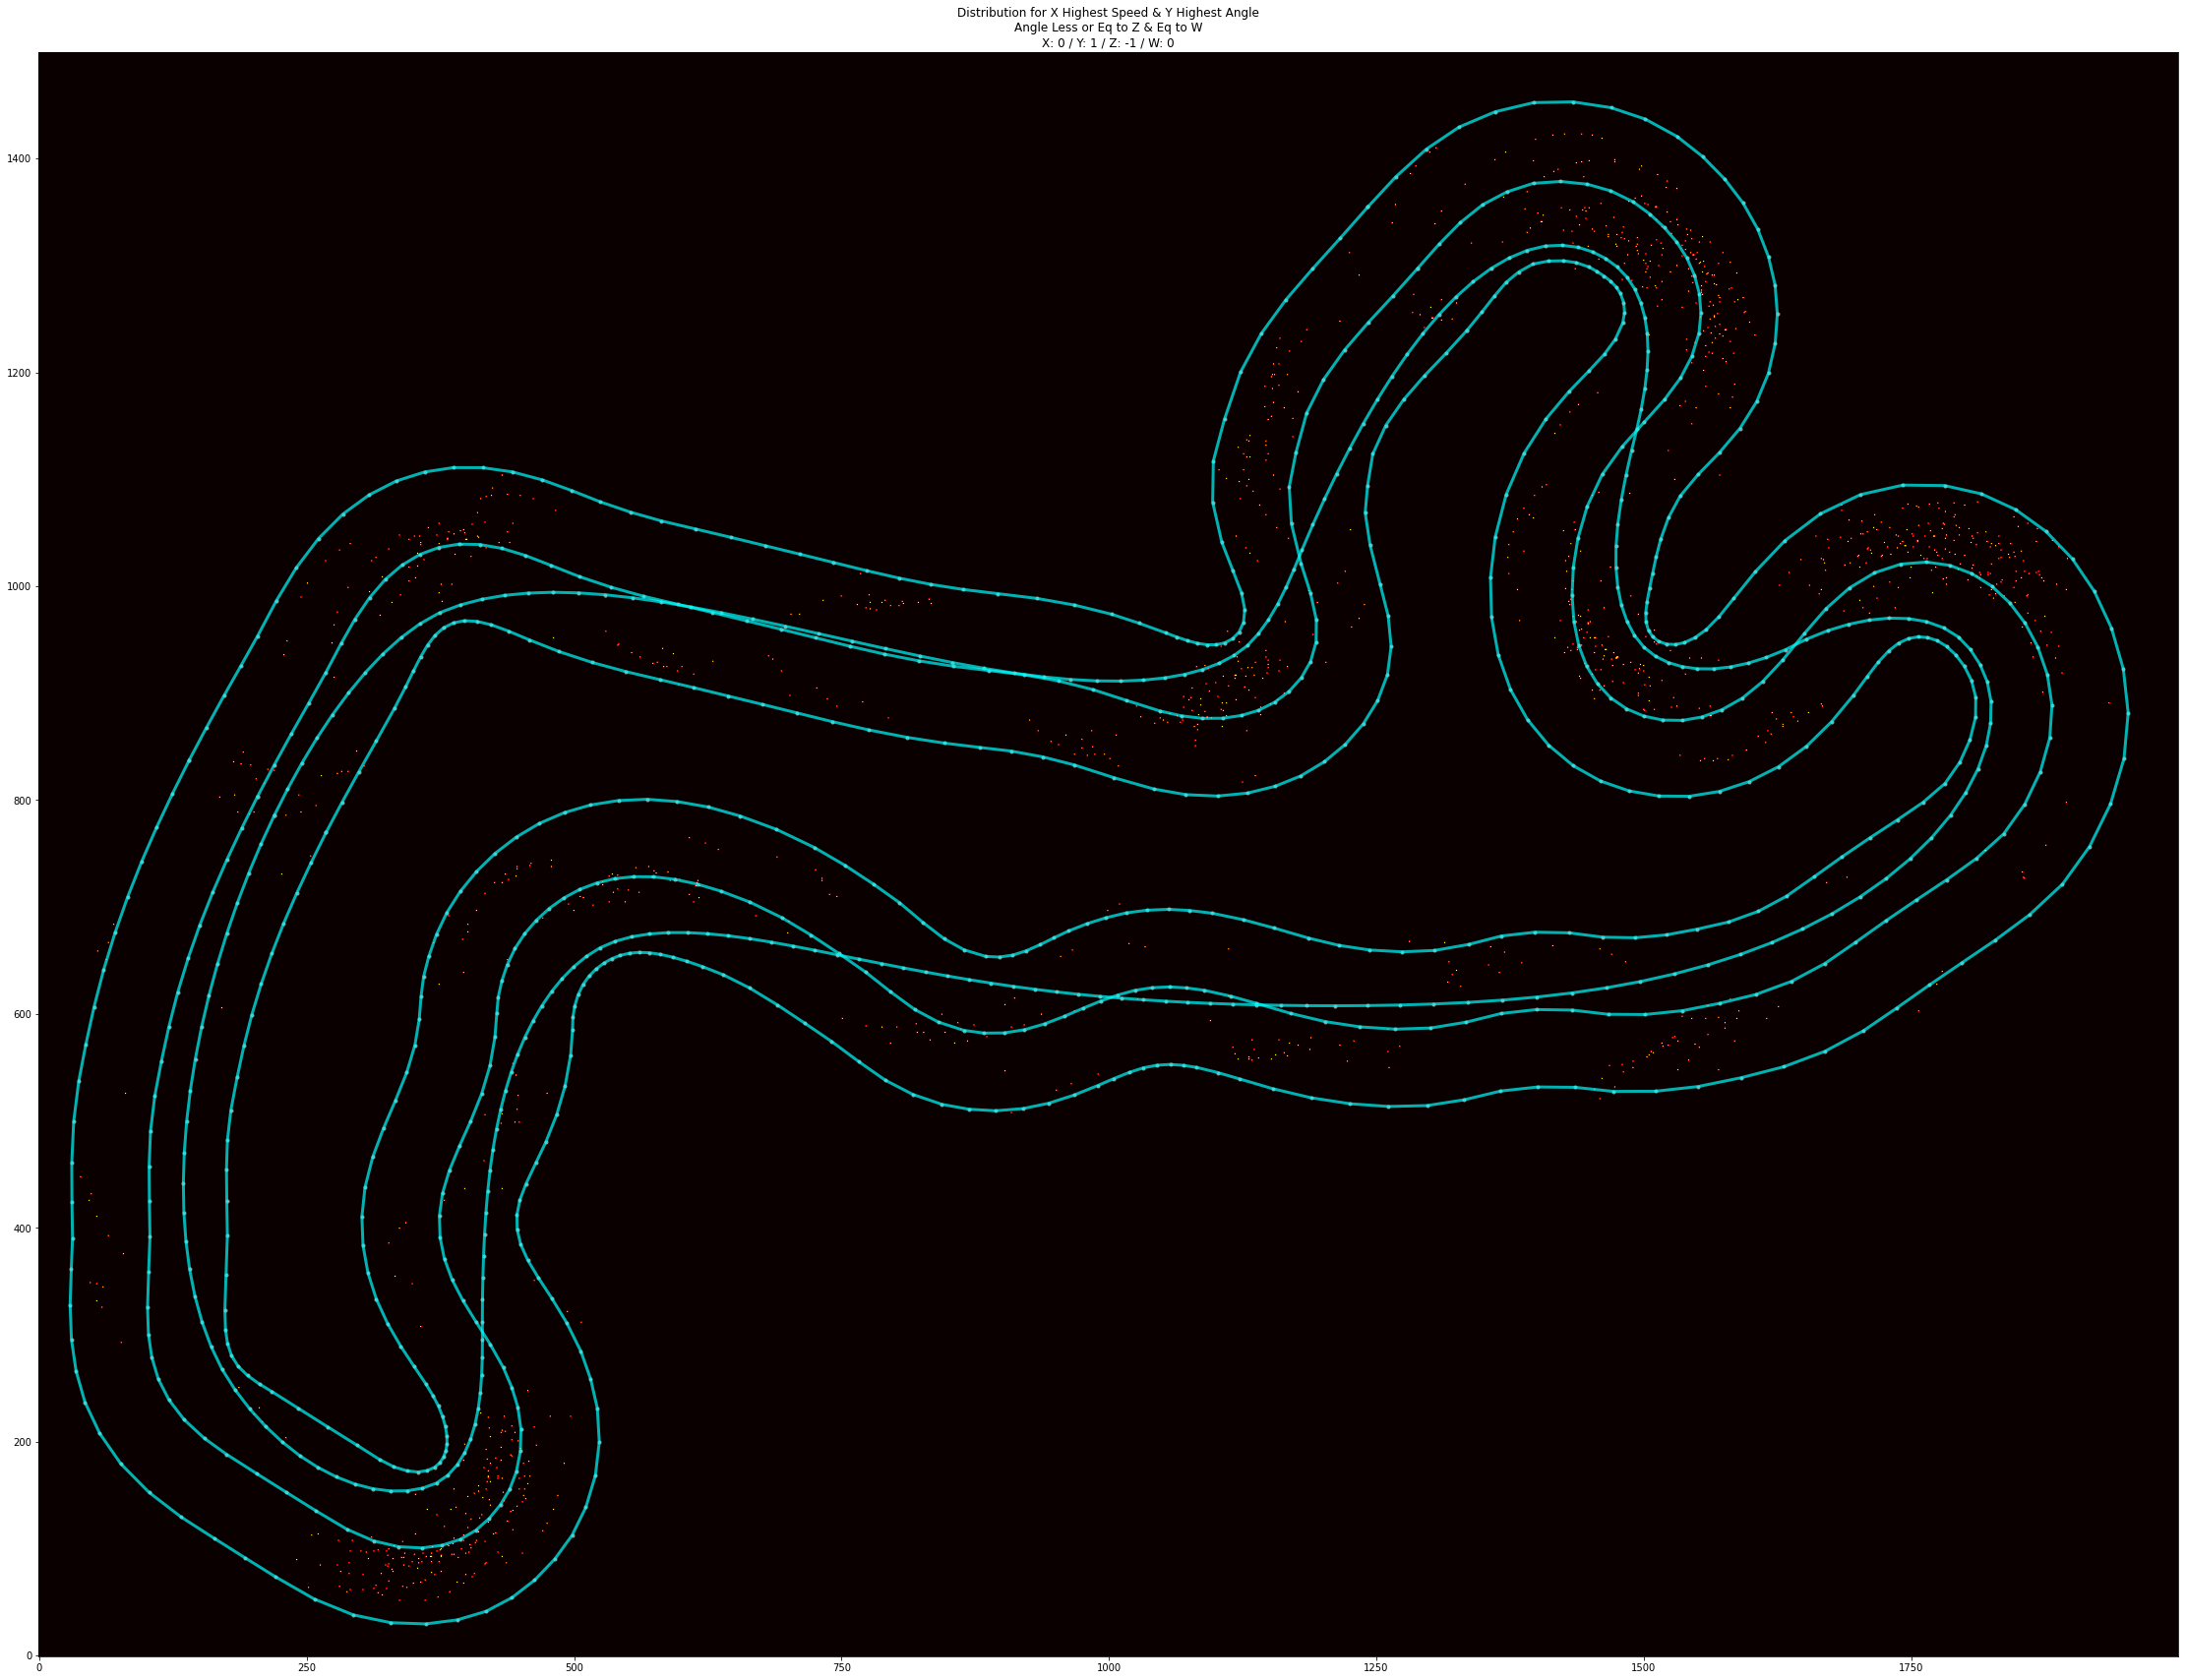

In [53]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 1, -1, 0, False)

# Plot Path Taken for the Fastest Completed Lap

In [54]:
def plot_top_laps(sorted_idx, n_laps=5, x_offset=0, y_offset=0, plot_yaw=False, plot_steer=False, plot_labels=False):
    fig = plt.figure(n_laps, figsize=(plot_x_max/50, plot_y_max/50*n_laps))
    for i in range(n_laps):
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(racing_track)
        plot_coords(ax, line)
        plot_line(ax, line)

        idx = sorted_idx[i]
        episode_data = sim_df[sim_df['episode']==idx]
        episode = sim_df_episodes[sim_df_episodes['episode']==idx]

        plt.title('Episode: %s (Iteration: %d, Episode-in-Iteration: %d), Steps: %d, Progress: %.2f, Rewards: %.2f, Elapsed Time: %.2fs, Status: %s' % (idx, episode['iteration'], episode['episode_in_iteration'], episode['steps'], episode['progress'], episode['episode_total_rewards'], episode['elapsed_time'], episode['status'].values[0]))
        for index, row in episode_data.iterrows():
            x1 = row['x']
            y1 = row['y']
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1+x_offset, car_x2+x_offset], [y1+y_offset, car_y2+y_offset], 'b.')
            
            if (plot_yaw):
                dx = 5*row['throttle']*math.cos(row['yaw']*math.pi/180)
                dy = 5*row['throttle']*math.sin(row['yaw']*math.pi/180)
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc='b', ec='b', zorder=99)
    
            if (plot_steer):
                dx = 5*row['throttle']*math.cos((row['yaw']+row['steer'])*math.pi/180)
                dy = 5*row['throttle']*math.sin((row['yaw']+row['steer'])*math.pi/180)
                if row['steer'] < 0:
                    steer_color = 'r'
                elif row['steer'] > 0:
                    steer_color = 'lime'
                else:
                    steer_color = 'y'
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc=steer_color, ec=steer_color, zorder=99)

            if (plot_labels):
                label_txt = '  STP: %s, WP: %s, HD:%0.2f, STR:%s, THR:%s' % (row['steps'], row['closest_waypoint'], row['yaw'], row['steer'], row['throttle'])
                plt.text(x1+x_offset, y1+y_offset, label_txt)
                print(label_txt)
    return fig



In [55]:
sim_df_episodes_fastest_full_lap = sim_df_episodes[sim_df_episodes['progress']>=100.0].sort_values('elapsed_time', ascending=True).head(1)
sim_df_episodes_fastest_full_lap

iteration  episode_in_iteration  episode  steps  progress  \
14554          4                    24      184    292     100.0   

             status  episode_total_rewards  elapsed_time    start_time  \
14554  lap_complete               705.1625     29.297429  1.607213e+09   

           end_time  
14554  1.607213e+09

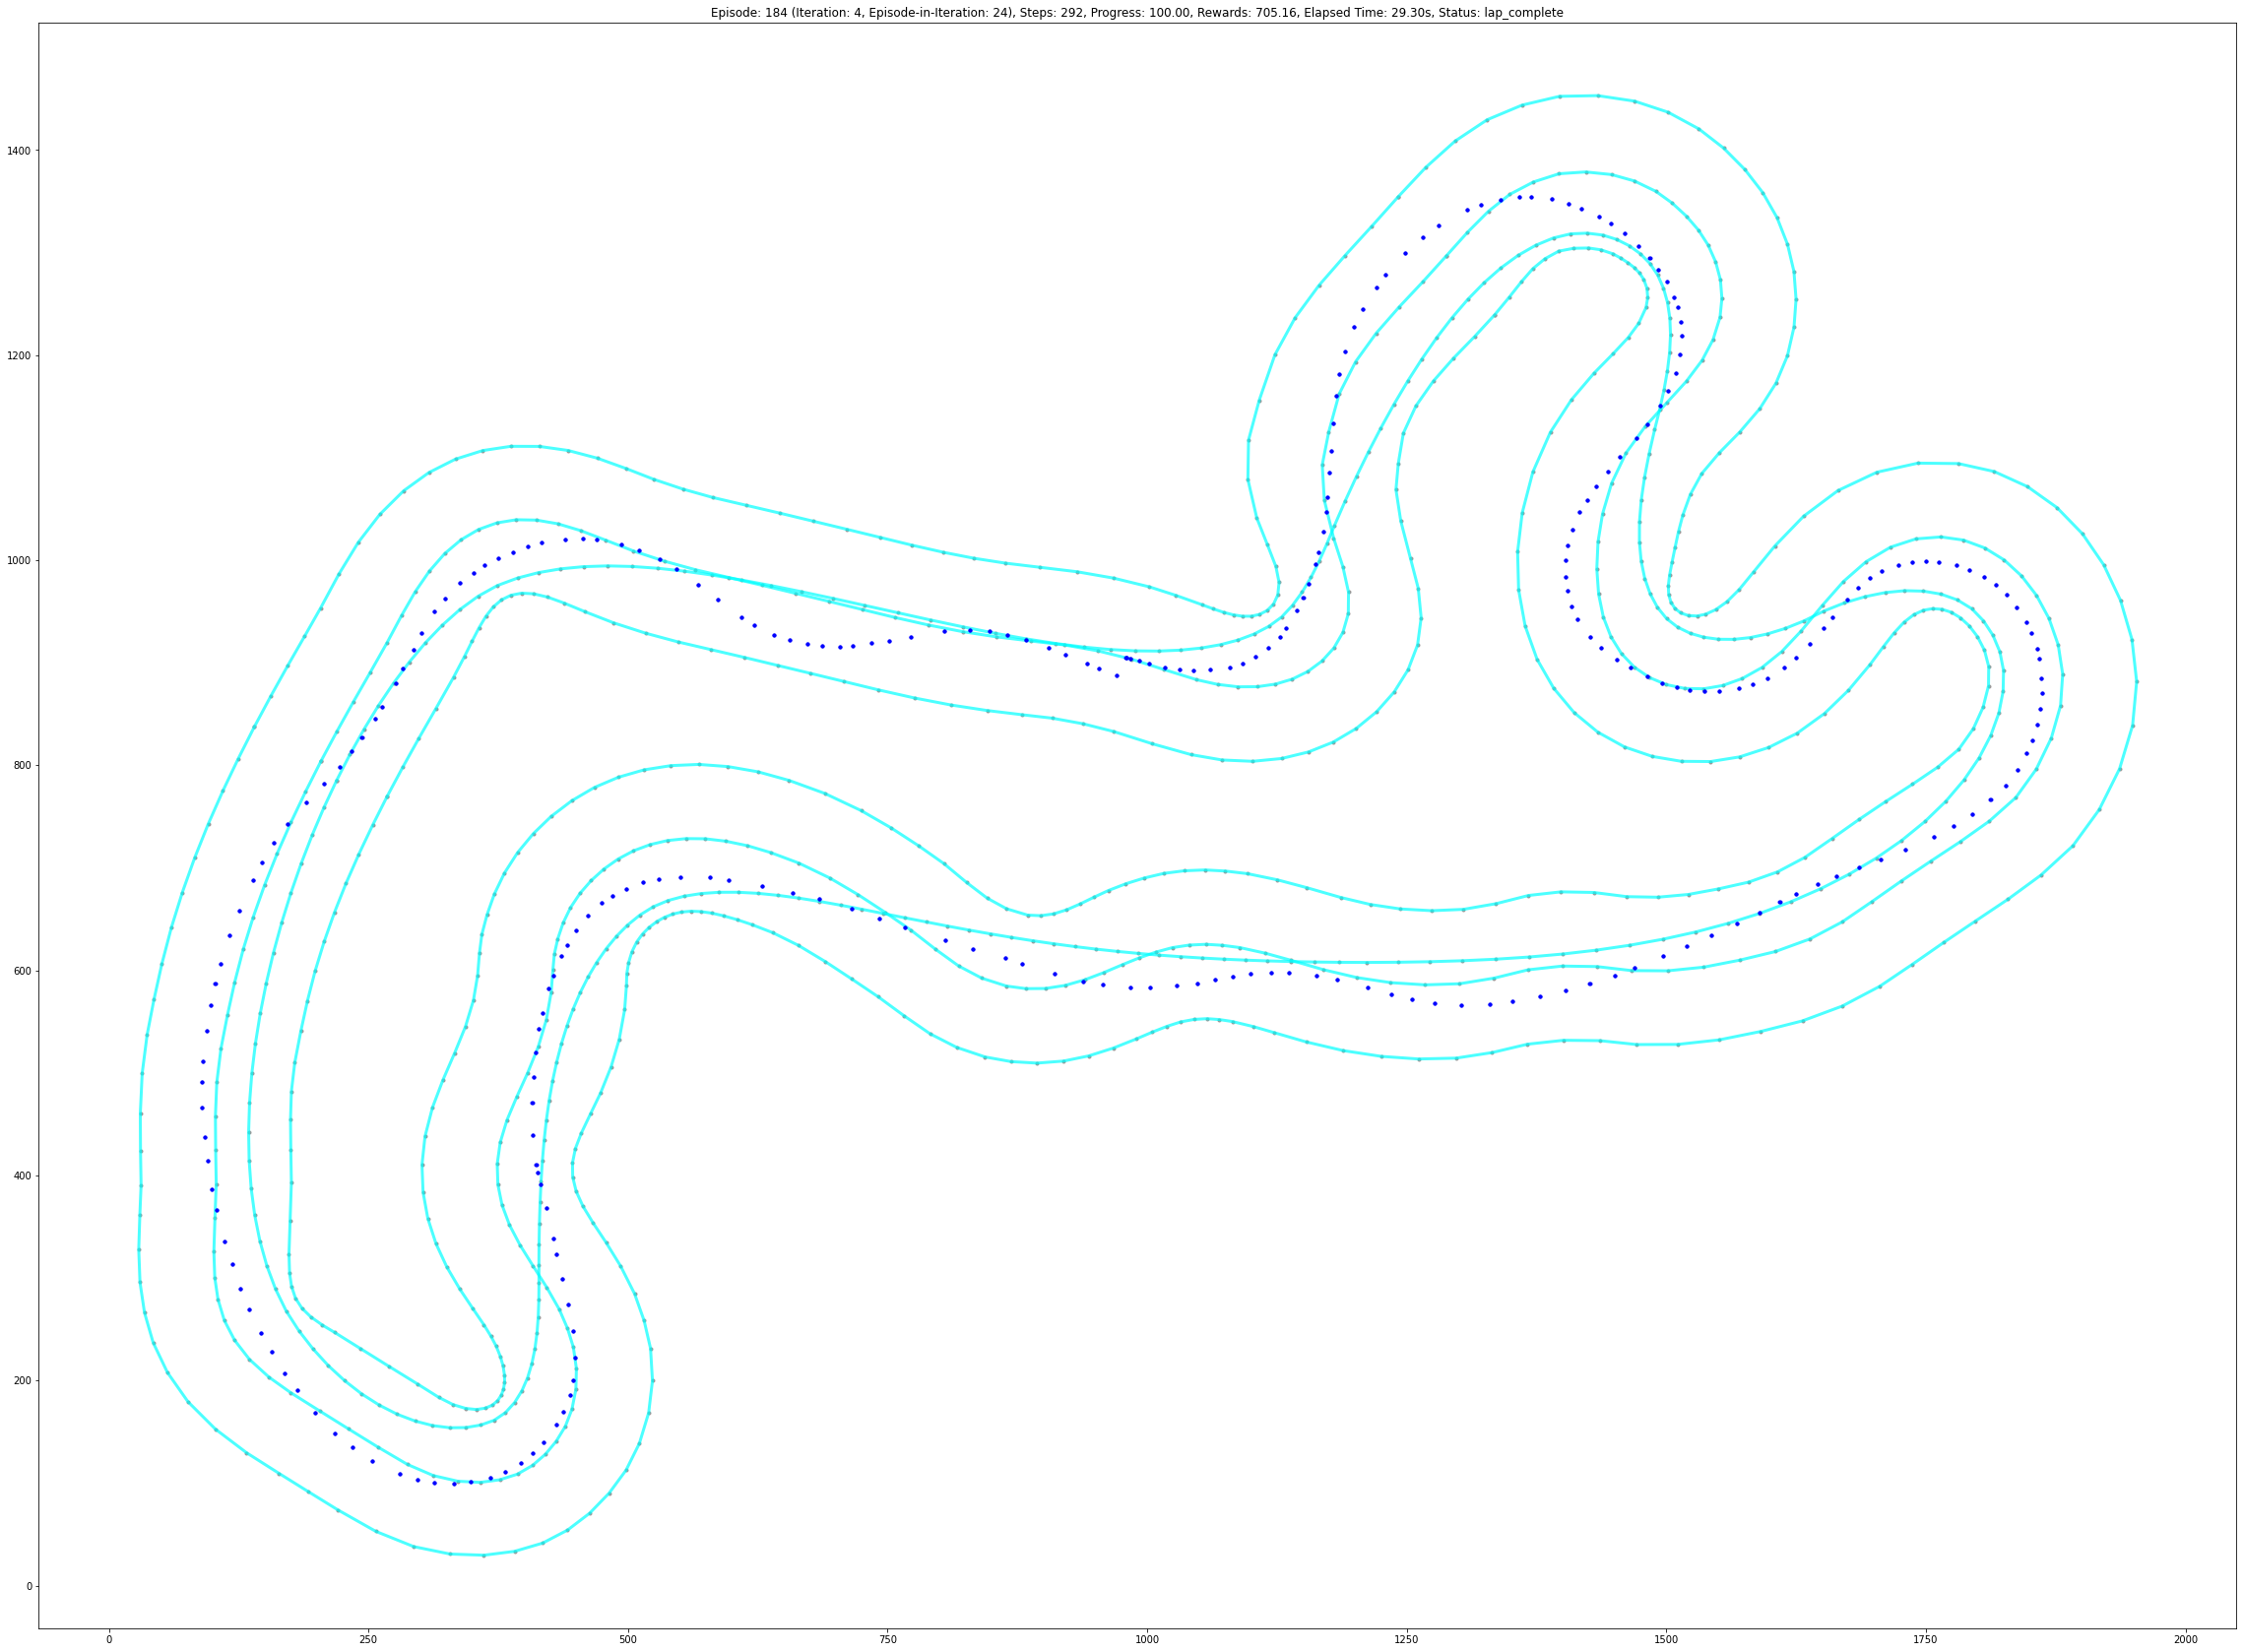

In [56]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset)

# Plot the Vectors of the Steps Taken Throughout the Fastest Lap
For any given step:
- Blue arrow indicates the HEADING of the car
- Green arrow indicates that the car is steering LEFT
- Yellow arrow indicates that the car is steering STRAIGHT
- Red arrow indicate that the car is steering RIGHT
- The length of each arrow indicates the relative speed of the car

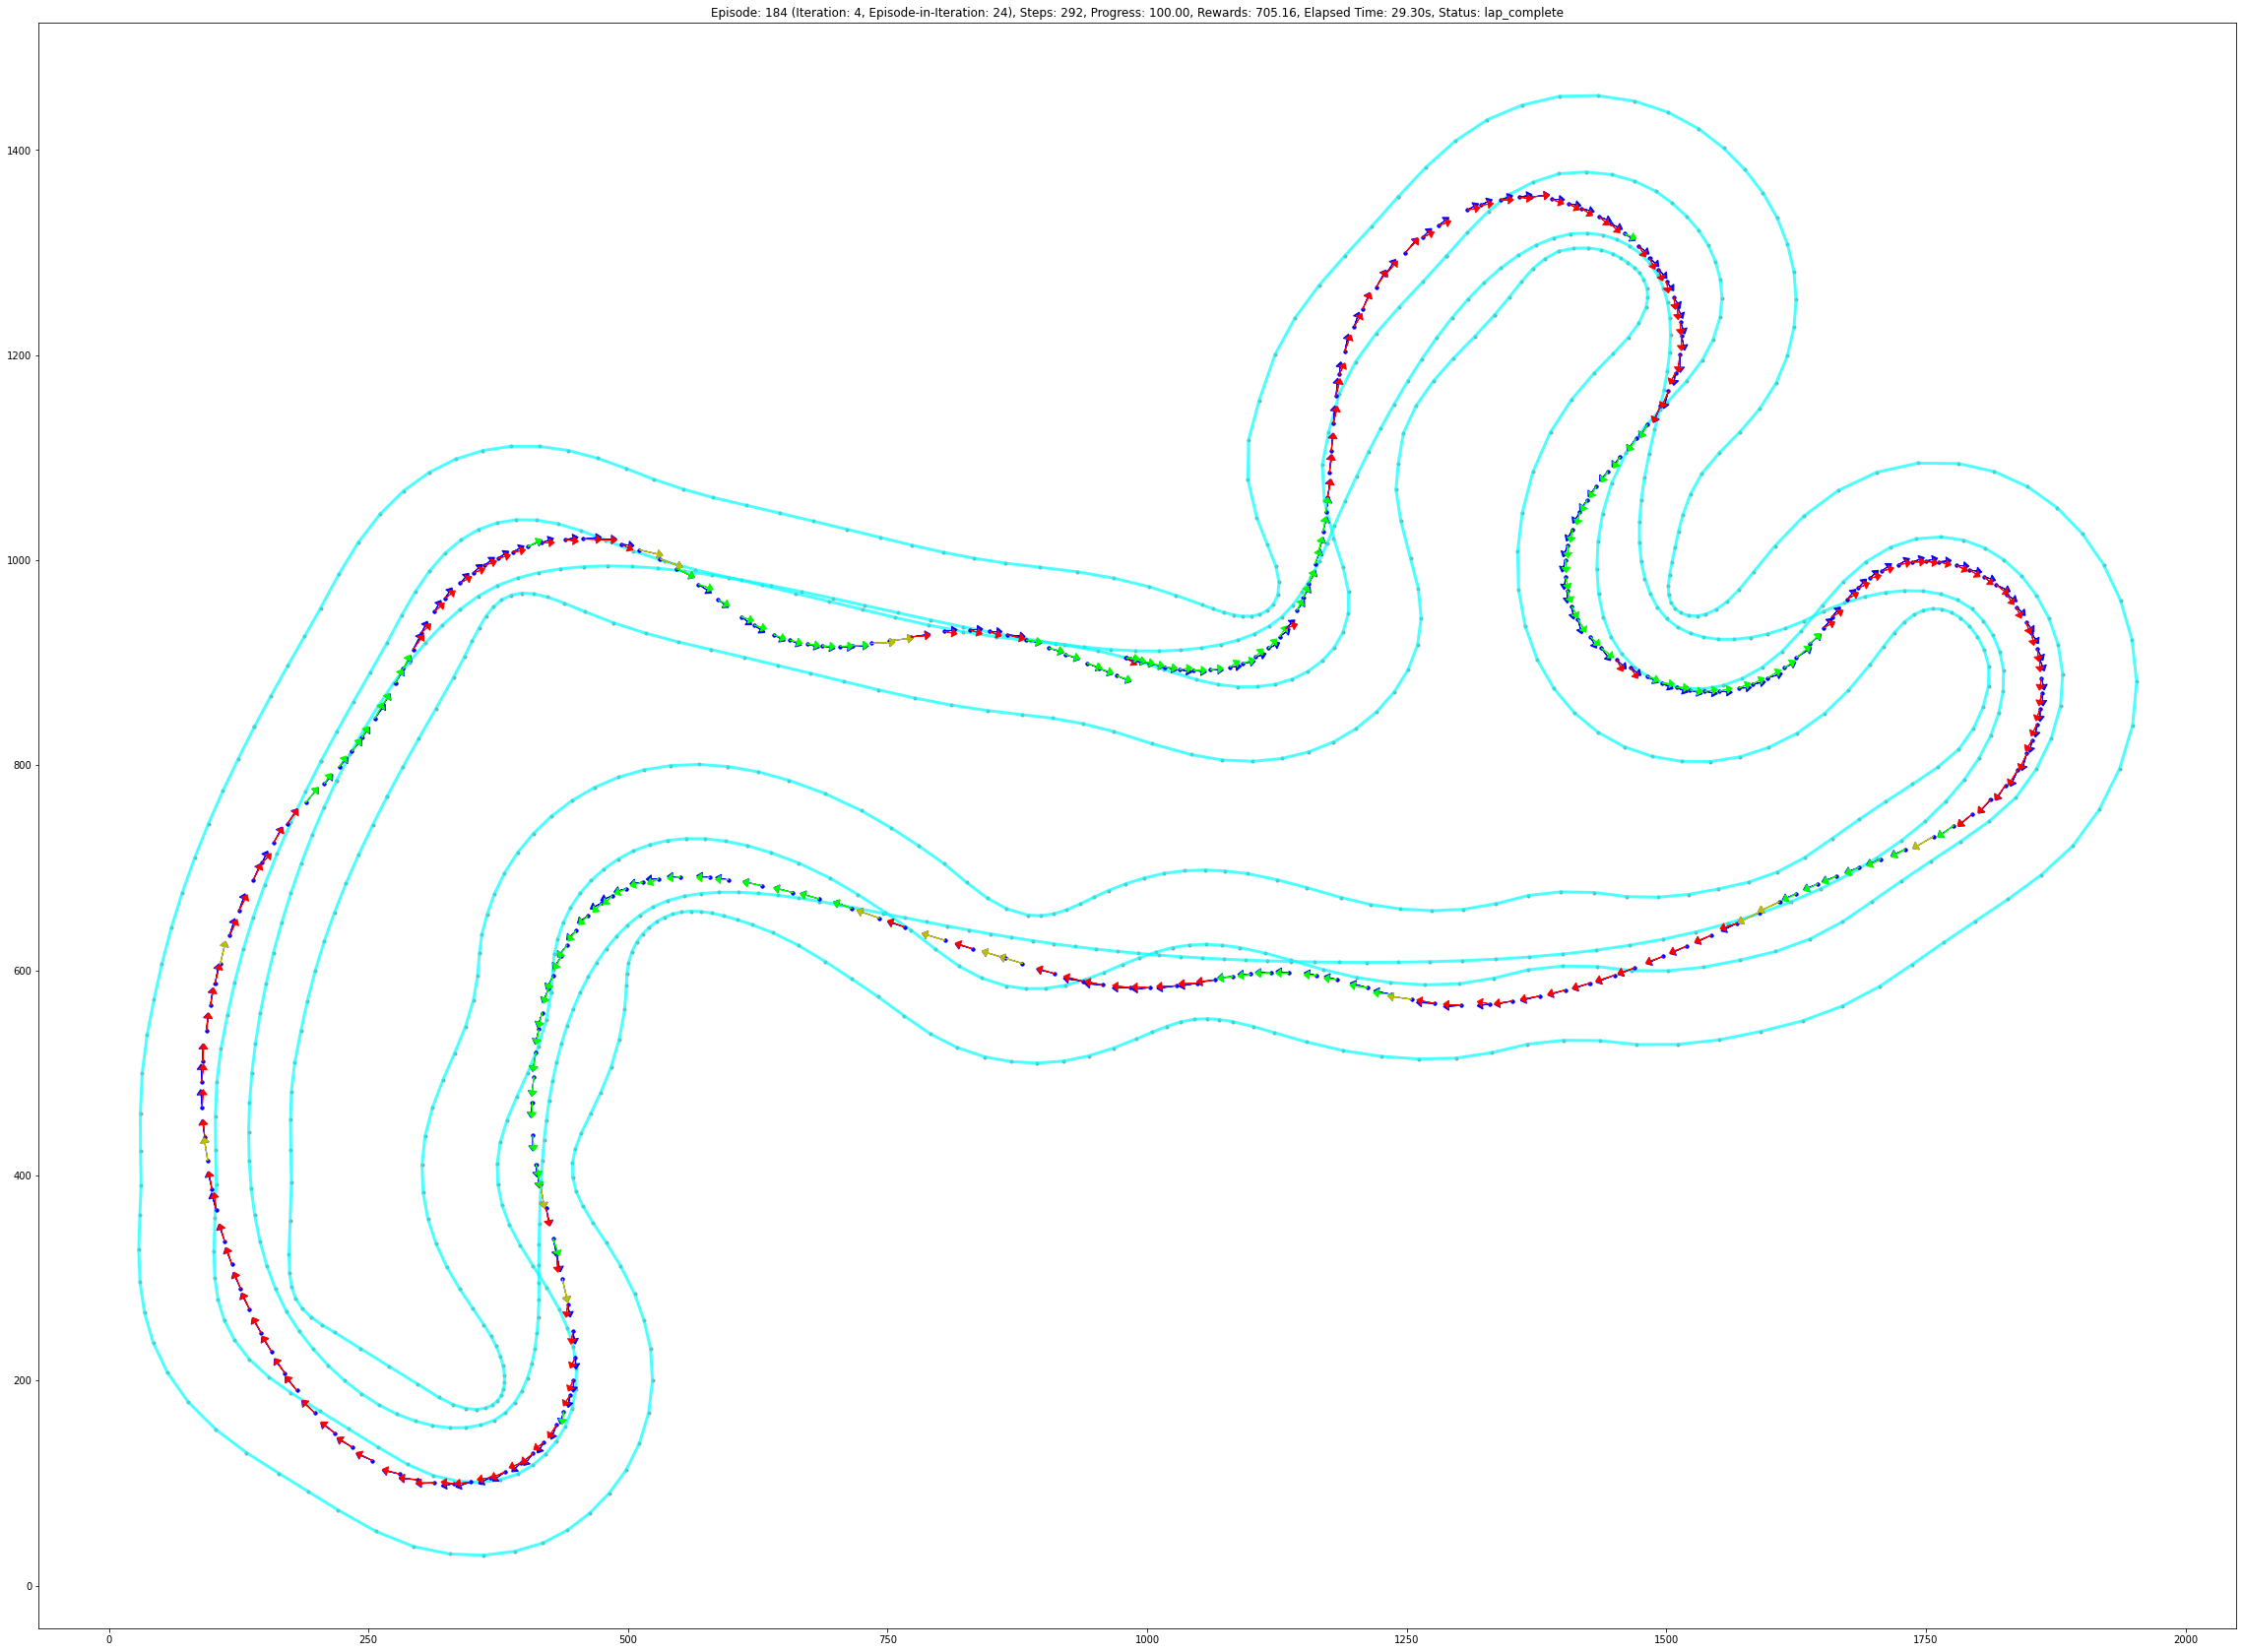

In [57]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset, True, True)

In [58]:
fpath = "./racelines/Monaco-1500-4-2020-11-30-215016.npy"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
#racing_track = racing_track.tolist()[:]

In [59]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints(WORLD_NAME)
waypoints.shape

(235, 6)

In [60]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        if i % 5 == 0:
            ax.annotate(i, (p[0], p[1]))
        #else:
            #ax.annotate('*', (p[0], p[1]), color=color)

def plot_line(ax, ob, color):
    ob = LineString(ob)                                                
    x, y = ob.xy                                                                
    ax.plot(x, y, color=color, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2)


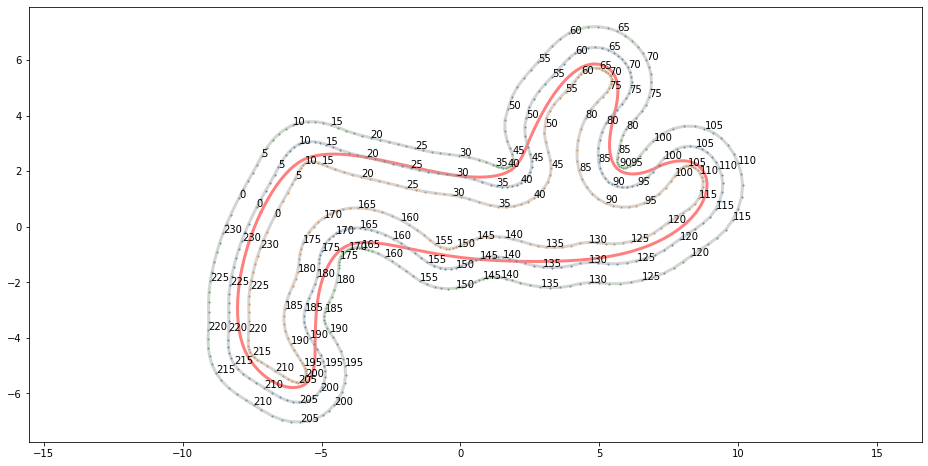

In [61]:
# Plot the results
fig, ax = plt.subplots(figsize=(16,8))


plot_line(ax, racing_track, 'red' )
plot_line(ax, waypoints[:,0:2], '#aaaaaa')
plot_line(ax, waypoints[:,2:4], '#aaaaaa')
plot_line(ax, waypoints[:,4:6], '#aaaaaa')

plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()